#   **Introduction**

### Goals

* Extract data from the FDA about Drug Adverse Reactions
  1. Use openFDA API to gather data
  
  
* Analyze these findings to see
  1. What trends do we see in reporting
  2. What information can we get about drug manufacturers
    * are some producing more adverse reaction reports than others?
    * are there trends for different manufacturers?
    * are some manufacturers more responsible for the overall trends we see in reporting than others?
  3. If we can accurately predict whether a reaction will be serious or not given various predictors
  4. Forecast the number of serious and non-serious adverse reactions five years into the future

### Importing libraries and data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pickle
import json
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit


warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_style("darkgrid")
%matplotlib inline

In [4]:
#final dataframe was pickled using make_dataframe.py
data = pickle.load(open('pickles/final_dataframe.p', 'rb'))

In [87]:
print(data.shape)
data.tail()

(451836, 26)


,transmissiondate,fulfillexpeditecriteria,occurcountry,receiptdate,serious,companynumb,safetyreportid,patientsex,reactionmeddrapt,reactionoutcome,...,drugbatchnumb,drugintervaldosageunitnumb,drugdosagetext,actiondrug,drugintervaldosagedefinition,drugauthorizationnumb,drugdosageform,drugstructuredosagenumb,activesubstancename,company
receivedate,,,,,,,,,,,,,,,,,,,,,
2019-03-31,20190418,2,US,20190331,2,US-JNJFOC-20190231040,16135297,1,"[Headache, Diarrhoea]","[6, 6]",...,[UNKNOWN],NaN,NaN,[5],NaN,[210455],[TABLET],NaN,[COBICISTAT\DARUNAVIR\EMTRICITABINE\TENOFOVIR ...,[Janssen Products LP]
2019-03-31,20190418,2,US,20190331,2,US-JNJFOC-20190311672,16135298,2,"[Product use issue, Wrong technique in product...","[6, 6, 6]",...,"[UNKNOWN;4803C, UNKNOWN;4803C]",NaN,"[UNKNOWN, JUST MEASURES IT INTO HER PALM ONCE ...","[4, 4]",NaN,"[999999, 021812]","[FOAM, FOAM]",NaN,"[MINOXIDIL, MINOXIDIL]",NaN
2019-03-31,20190418,2,US,20190331,1,US-CELGENEUS-USA-20190309736,16135363,1,[Malaise],[3],...,NaN,NaN,NaN,NaN,NaN,NaN,"[CAPSULES, CAPSULES, UNKNOWN, CAPSULES]",NaN,"[LENALIDOMIDE, LENALIDOMIDE, IXAZOMIB CITRATE,...",NaN
2019-03-31,20190418,2,US,20190331,2,US-TEVA-2019-US-1024181,16135365,1,"[Abdominal pain upper, Dyspepsia, Headache]","[1, 1, 1]",...,NaN,NaN,[100MG BY MOUTH HALF TO 1 TAB 30-60 MINUTES PR...,[1],NaN,[202503],[FILM-COATED TABLET],NaN,[SILDENAFIL],NaN
2019-03-31,20190418,2,US,20190331,2,US-TEVA-2019-US-1024830,16135366,2,[Pain in extremity],[6],...,NaN,NaN,NaN,[3],NaN,[81099],[TABLET],[2.5],[METHOTREXATE],NaN


In [225]:
data[data['serious'] == '1'].shape[0]

344622

In [221]:
print(data[data['serious'] == '1'].shape[0]/data.shape[0])


0.7627147903221523


## 1. Looking at adverse reactions by pharmaceutical manufacturer

First, let's see how much of our data has only **one drug** listed with their adverse reaction observation:

In [5]:
print(f'{round(len(data[~data.company.isna()])/(len(data[~data.company.isna()]) \
      + len(data[data.company.isna()]))*100, 2)}%')

27.17%


The reason we're only going to look at 27% of our data is because if the patients are taking more than one drug, it will be difficult if not impossibile to assign any theories of causalities to one drug (and its manufacturers) to another. The code below takes those cases.

In [6]:
by_company = data[~data.company.isna()]
by_company.company = by_company.company.apply(lambda x: x[0])
by_company.head()

,transmissiondate,fulfillexpeditecriteria,occurcountry,receiptdate,serious,companynumb,safetyreportid,patientsex,reactionmeddrapt,reactionoutcome,...,drugbatchnumb,drugintervaldosageunitnumb,drugdosagetext,actiondrug,drugintervaldosagedefinition,drugauthorizationnumb,drugdosageform,drugstructuredosagenumb,activesubstancename,company
receivedate,,,,,,,,,,,,,,,,,,,,,
2004-01-02,20041129,1,NaN,20031215,1,FR_030602521,4263892-5,2,[NO ADVERSE DRUG EFFECT],NaN,...,NaN,NaN,[60 MG/DAY],NaN,NaN,[20815],NaN,NaN,NaN,Eli Lilly and Company
2004-01-02,20041129,1,NaN,20030706,1,PHNU2003DE02608,4262371-9,1,"[CUTANEOUS LUPUS ERYTHEMATOSUS, LUPUS-LIKE SYN...",NaN,...,NaN,NaN,"[80 MG, QD]",NaN,NaN,NaN,NaN,NaN,NaN,Novartis Pharmaceuticals Corporation
2004-01-02,20041129,1,NaN,20031222,1,USA030845403,4263775-0,2,[PNEUMONIA],NaN,...,NaN,NaN,[1200 MG],NaN,NaN,[20509],NaN,NaN,NaN,Eli Lilly and Company
2004-01-02,20041129,1,NaN,20031219,1,KDL047403,4264326-7,NaN,"[CARCINOMA, MALIGNANT NEOPLASM PROGRESSION]",NaN,...,[P007981],NaN,"[20000 U, WEEKLY, SC]",NaN,NaN,NaN,NaN,NaN,NaN,"Janssen Products, LP"
2004-01-02,20041129,1,NaN,20031222,1,US-JNJFOC-20030905472,4263791-9,1,[MUSCLE INJURY],NaN,...,NaN,NaN,NaN,NaN,NaN,[20634],NaN,NaN,NaN,"Janssen Pharmaceuticals, Inc."


In [7]:
grouped_company = by_company.groupby(['receivedate', 'company', 'serious'])
detailed_company = grouped_company.size()
detailed_company

receivedate  company                               serious
2004-01-02   Biogen Inc.                           1           3
             Eli Lilly and Company                 1           5
             GlaxoSmithKline LLC                   1           1
             Janssen Biotech, Inc.                 1           1
             Janssen Pharmaceuticals, Inc.         1           1
                                                              ..
2019-03-31   Janssen Pharmaceuticals, Inc.         2           2
             Janssen Products LP                   2           1
             Novartis Pharmaceuticals Corporation  1          11
                                                   2           8
             Pharmacyclics LLC                     2           2
Length: 43948, dtype: int64

What the results above show is the **receive data** (granularity: one day), the **company**, whether it was a **serious** reaction or not, and the **total count** of observations

Now, below, we want to see if there is a difference between our entire data and our subset data with company information. If the method of data collection changed, we'd likely see its effect here. If this is the case, we have to be careful going forward with analyzing our results.

In [8]:
yearly_reactions = detailed_company.groupby(detailed_company.index.get_level_values(level = 0).year).sum()

all_size =  data.groupby(['receivedate']).size()
yearly_reactions_all = all_size.groupby(all_size.index.year).sum()

Let's now plot the amounts of adverse reactions with only one drug (and its manufacturer) as well as all adverse reactions.

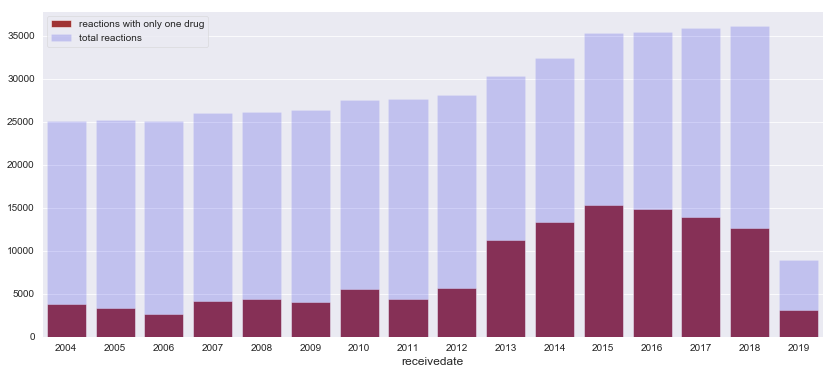

In [9]:
plt.figure(figsize = (14,6))
sns.barplot(x = yearly_reactions.index, y = yearly_reactions.values, color = 'firebrick', label = 'reactions with only one drug')
sns.barplot(x = yearly_reactions_all.index, y = yearly_reactions_all.values, color = 'blue', alpha = .2, label = 'total reactions')
plt.legend()
plt.show()

It looks as though both sets follow the same trend, which is good, but it also looks as though the reactions with one drug (i.e. our company information) is getting to be a larger and larger part of our data. Let's chart it.

In [10]:
reactions_percentages = yearly_reactions/(yearly_reactions_all+yearly_reactions)*100

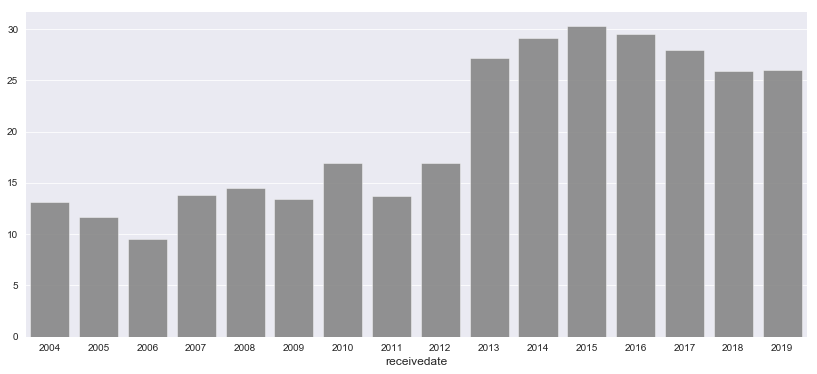

In [11]:
plt.figure(figsize = (14,6))
sns.barplot(x = reactions_percentages.index, y = reactions_percentages.values, color = 'gray', alpha = .85)
plt.show()

So this really points to a difference between pre-2013 and post-2012. In order to make sure if there's a statistically significant different between these two groups, we'll do a simple student's t-test (by month, not year).

Now we know there is probably a real difference in how reactions were recorded pre-2013 and post-2012. This is important to keep in mind when interpreting the results of our other analyses.

Next, we will split our data up into serious and non-serious reactions (by company)

In [12]:
#serious ones
detailed_company_serious = detailed_company[detailed_company.index.get_level_values(level = 2) == '1'].reset_index()
detailed_company_serious = detailed_company_serious.set_index('receivedate').drop(columns = 'serious').rename(columns = {0: 'observations'})

#not serious ones
detailed_company_not_serious = detailed_company[detailed_company.index.get_level_values(level = 2) == '2'].reset_index()
detailed_company_not_serious = detailed_company_not_serious.set_index('receivedate').drop(columns = 'serious').rename(columns = {0: 'observations'})

In [13]:
detailed_company_serious.head()

,company,observations
receivedate,,
2004-01-02,Biogen Inc.,3
2004-01-02,Eli Lilly and Company,5
2004-01-02,GlaxoSmithKline LLC,1
2004-01-02,"Janssen Biotech, Inc.",1
2004-01-02,"Janssen Pharmaceuticals, Inc.",1


I select out the top twenty companies with the largest number of total adverse reactions for serious and non-serious and create a list from the union of those top ones.

In [14]:
top_serious = set(detailed_company_serious['company'].value_counts()[:20].index)
top_not_serious = set(detailed_company_not_serious['company'].value_counts()[:20].index)
top_company_names = top_serious.union(top_not_serious)
np.asarray(top_company_names)

array({'Immunex Corporation', 'Boehringer Ingelheim Pharmaceuticals Inc.', 'Wyeth Pharmaceuticals LLC, a subsidiary of Pfizer Inc.', 'Janssen Pharmaceuticals, Inc.', 'Biogen Inc.', 'Boehringer Ingelheim Pharmaceuticals, Inc.', 'EMD Serono, Inc.', 'Organon USA Inc.', 'AstraZeneca Pharmaceuticals LP', 'Teva Neuroscience, Inc.', 'Alcon Laboratories, Inc.', 'AbbVie Inc.', 'Genentech, Inc.', 'Eli Lilly and Company', 'Janssen Biotech, Inc.', 'Bayer HealthCare Pharmaceuticals Inc.', 'Amgen Inc', 'E.R. Squibb & Sons, L.L.C.', 'Pfizer Laboratories Div Pfizer Inc', 'Celgene Corporation', 'GlaxoSmithKline LLC', 'Novartis Pharmaceuticals Corporation', 'UCB, Inc.', 'Otsuka America Pharmaceutical, Inc.', 'Merck Sharp & Dohme Corp.'},
      dtype=object)

Now we have to filter our serious and non-serious data frames for only the top manufacturers.

In [15]:
detailed_company_serious_top = detailed_company_serious[detailed_company_serious['company'].isin(top_company_names)]
detailed_company_not_serious_top = detailed_company_not_serious[detailed_company_not_serious['company'].isin(top_company_names)]

In [21]:
#merge two dataframes again
together_companies = detailed_company_serious_top.merge(detailed_company_not_serious_top, on = ['receivedate', 'company'], how = 'outer')
together_companies = together_companies.rename(columns = {'observations_x': 'serious_obs', 'observations_y': 'non-serious_obs'})
together_companies = together_companies.fillna(0)

#feature engineering
together_companies['difference'] = together_companies['non-serious_obs'] - together_companies['serious_obs']
#together_companies['percentage'] = round(together_companies['serious_obs']/(together_companies['serious_obs'] + together_companies['non-serious_obs'])*100, 2)
together_companies['total'] = together_companies['non-serious_obs'] + together_companies['serious_obs']


Below is the summary table of the top companies and their reaction statistics.

In [27]:
company_stats = together_companies.groupby('company').sum().sort_values(by = ['serious_obs'], ascending = False)
company_stats


,serious_obs,non-serious_obs,difference,total
company,,,,
Amgen Inc,10493.0,802.0,-9691.0,11295.0
Immunex Corporation,7411.0,12653.0,5242.0,20064.0
"Genentech, Inc.",6769.0,293.0,-6476.0,7062.0
Biogen Inc.,6755.0,4986.0,-1769.0,11741.0
Novartis Pharmaceuticals Corporation,4289.0,3803.0,-486.0,8092.0
AbbVie Inc.,4260.0,990.0,-3270.0,5250.0
GlaxoSmithKline LLC,3221.0,602.0,-2619.0,3823.0
Bayer HealthCare Pharmaceuticals Inc.,3159.0,1390.0,-1769.0,4549.0
"E.R. Squibb & Sons, L.L.C.",2522.0,1781.0,-741.0,4303.0


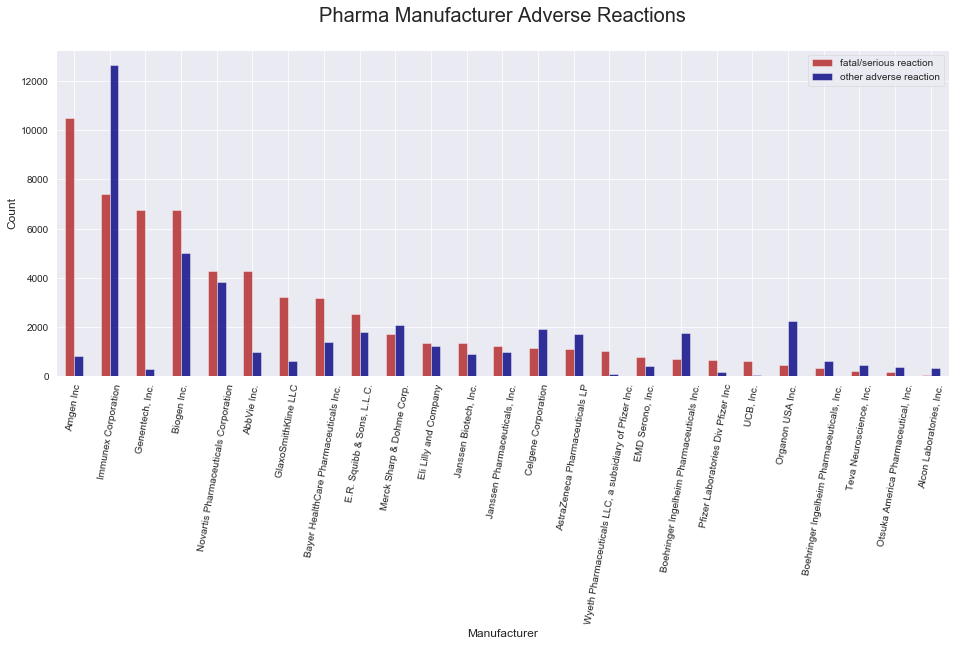

In [200]:
company_stats[['serious_obs', 'non-serious_obs']].plot.bar(color = ['firebrick', 'navy'], alpha = .8, figsize = (16,6))
plt.xticks(rotation = 80)
plt.title('Pharma Manufacturer Adverse Reactions\n', fontsize = 20)
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.legend(['fatal/serious reaction', 'other adverse reaction'])
plt.savefig('images/all_companies_bar.png', bbox_inches = "tight")
plt.show()

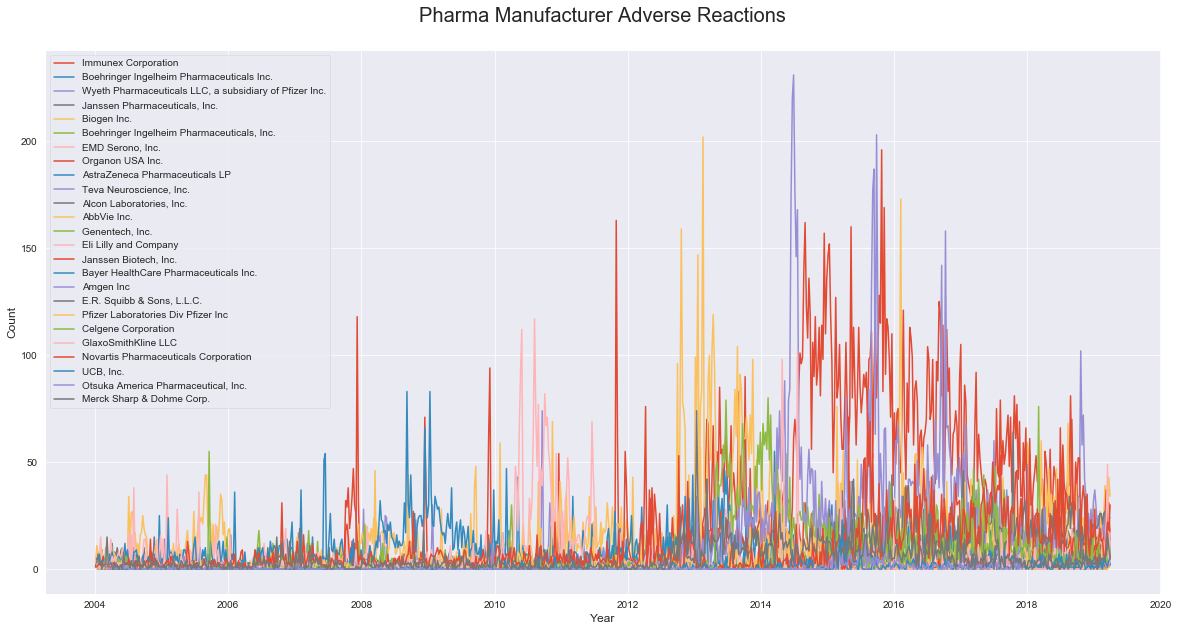

In [201]:
plt.figure(figsize = (20,10))
for company in top_company_names:
    df = together_companies[together_companies['company'] == company]
    df = df.groupby(pd.Grouper(freq="W")).sum()
    #plt.figure(figsize = (20,10))
    #sns.lineplot(x = df.index, y = df.serious_obs.values)
    sns.lineplot(x = df.index, y = df['total'].values)
    #plt.title(f'{company}')
plt.legend(top_company_names, loc = 2)
plt.title('Pharma Manufacturer Adverse Reactions\n', fontsize = 20)
plt.xlabel('Year')
plt.ylabel('Count')
plt.savefig('images/all_companies_week.png', bbox_inches = "tight")

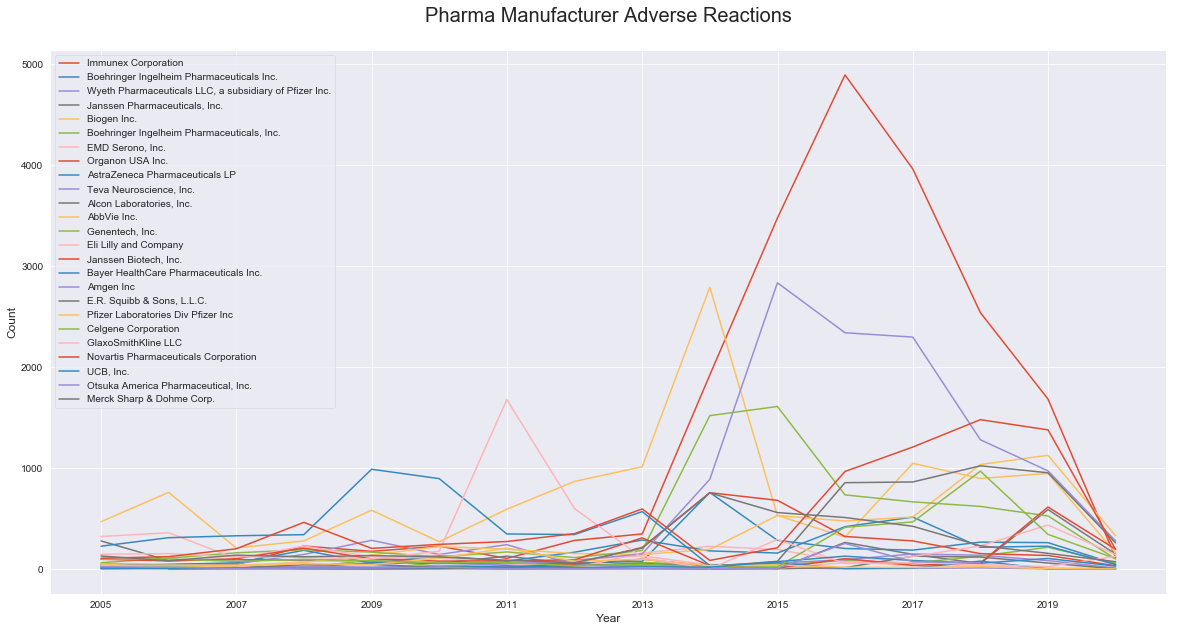

In [199]:
plt.figure(figsize = (20,10))
for company in top_company_names:
    df = together_companies[together_companies['company'] == company]
    df = df.groupby(pd.Grouper(freq="Y")).sum()
    #plt.figure(figsize = (20,10))
    #sns.lineplot(x = df.index, y = df.serious_obs.values)
    sns.lineplot(x = df.index, y = df['total'].values)
    #plt.title(f'{company}')
plt.legend(top_company_names, loc = 2)
plt.title('Pharma Manufacturer Adverse Reactions\n', fontsize = 20)
plt.xlabel('Year')
plt.ylabel('Count')
plt.savefig('images/all_companies_year.png')

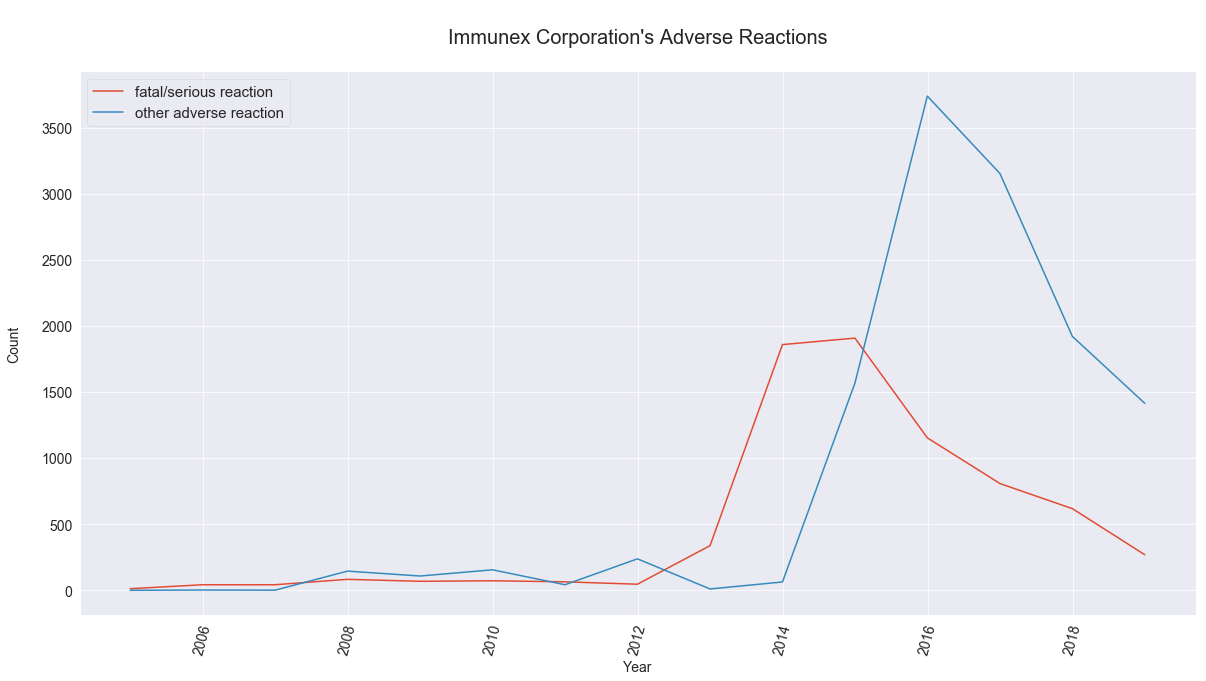

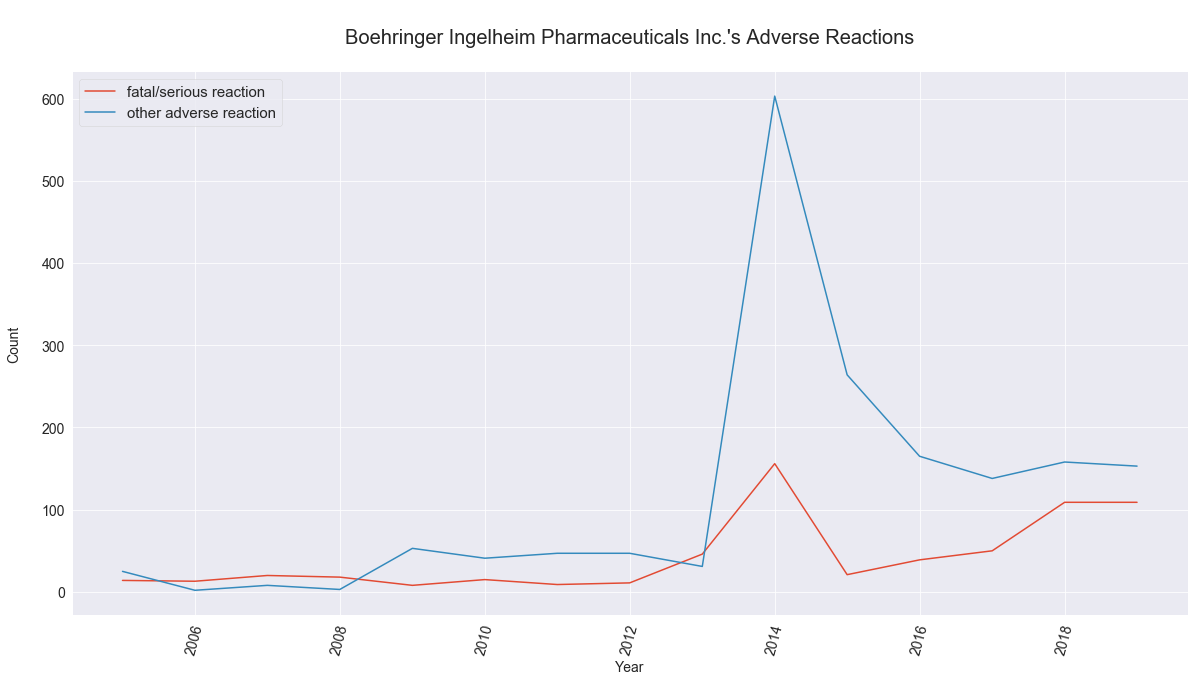

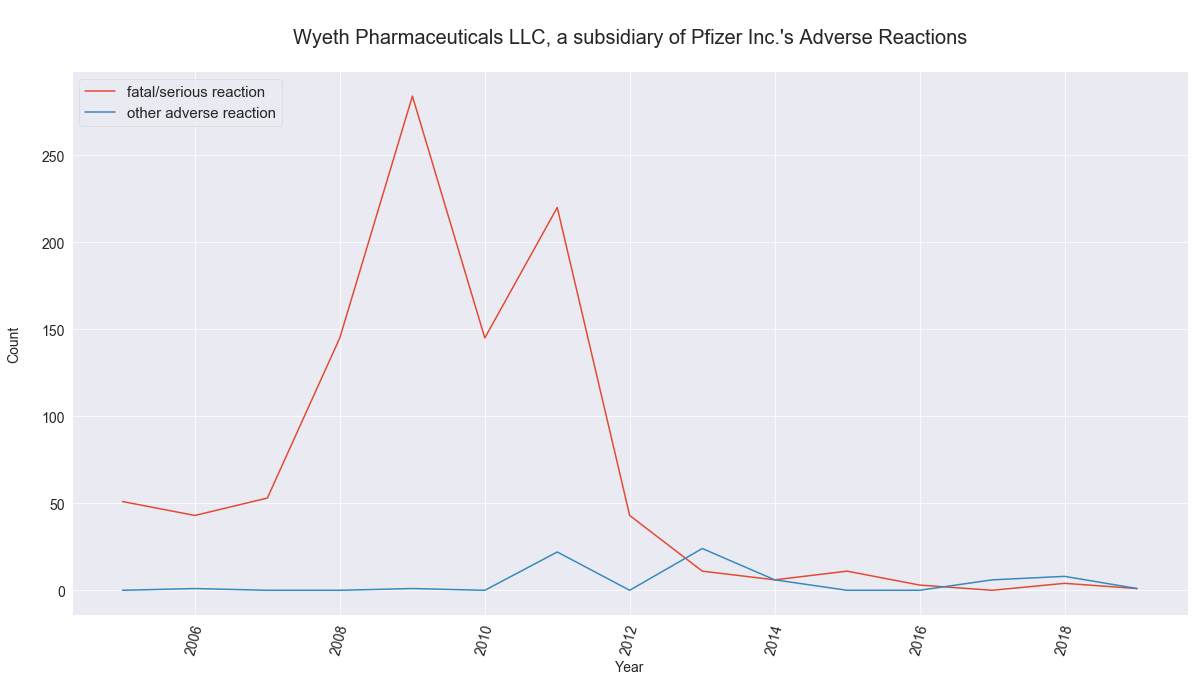

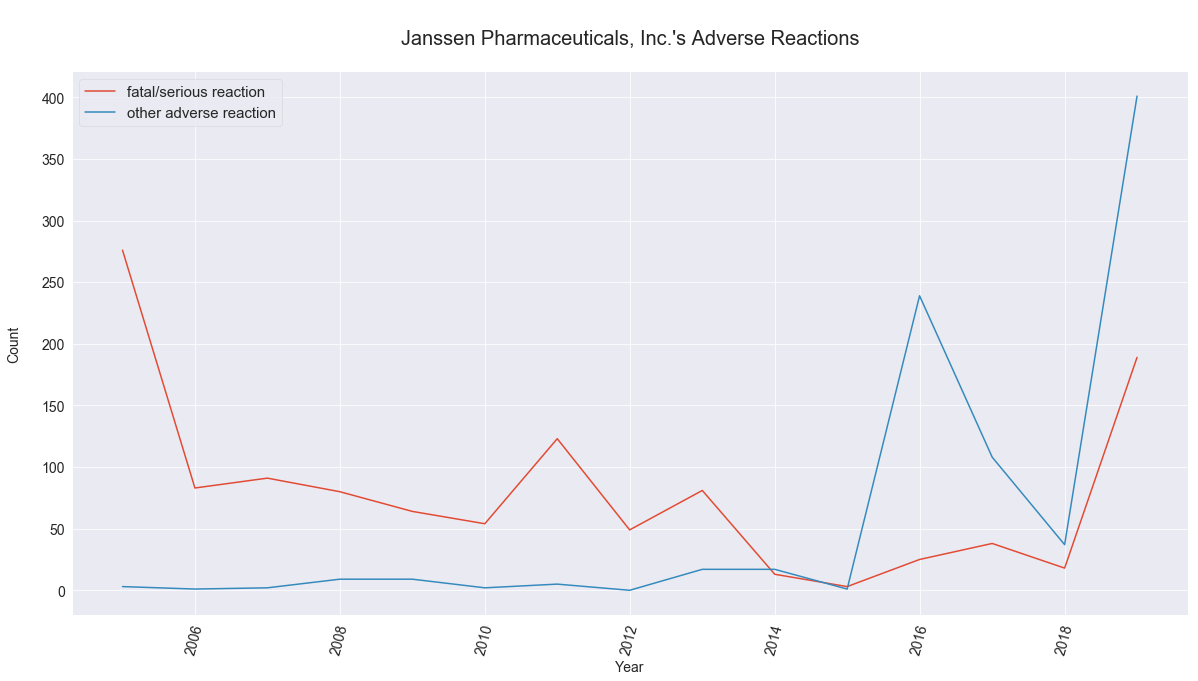

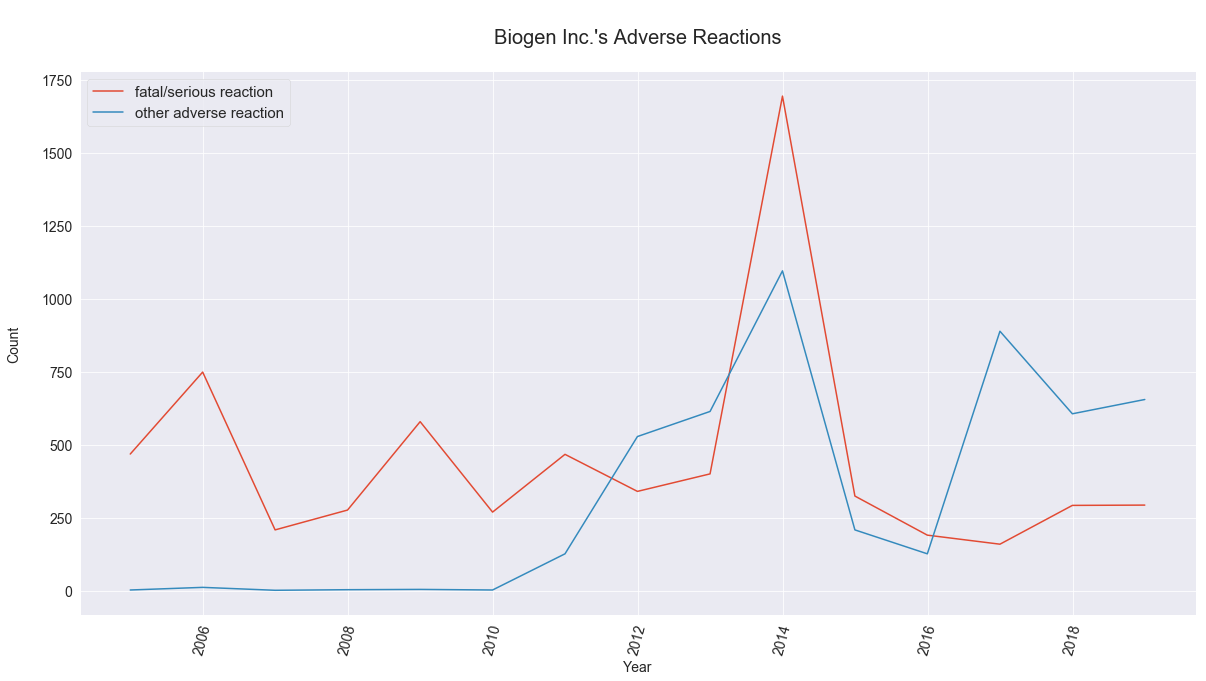

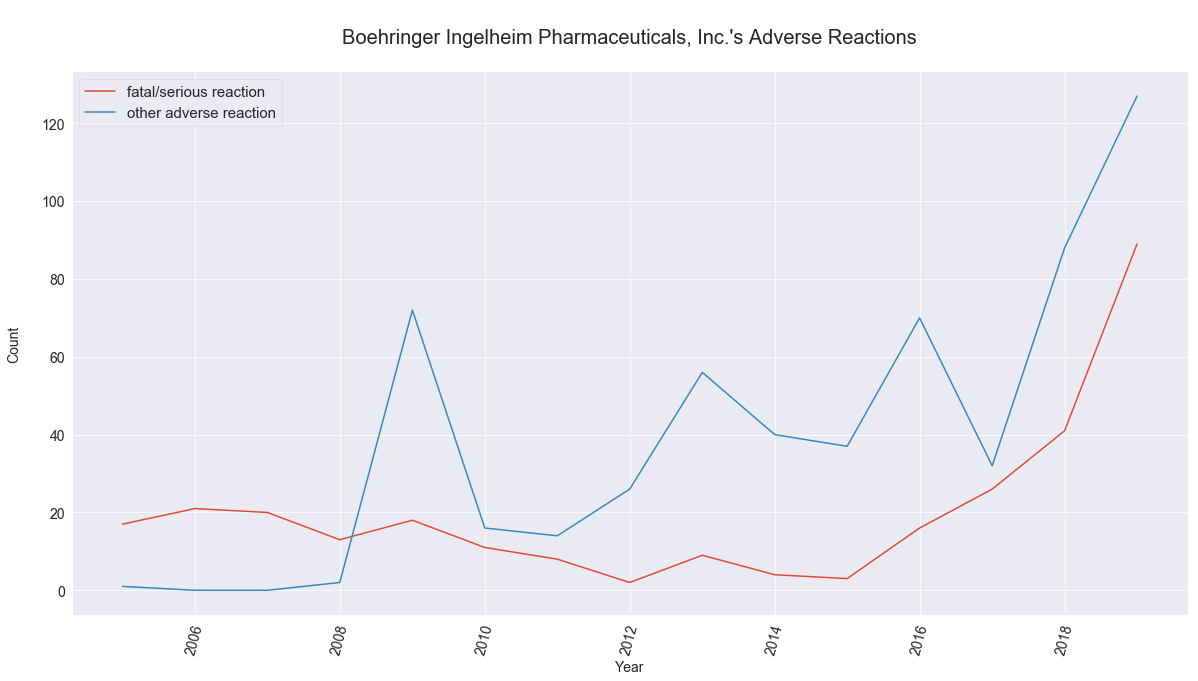

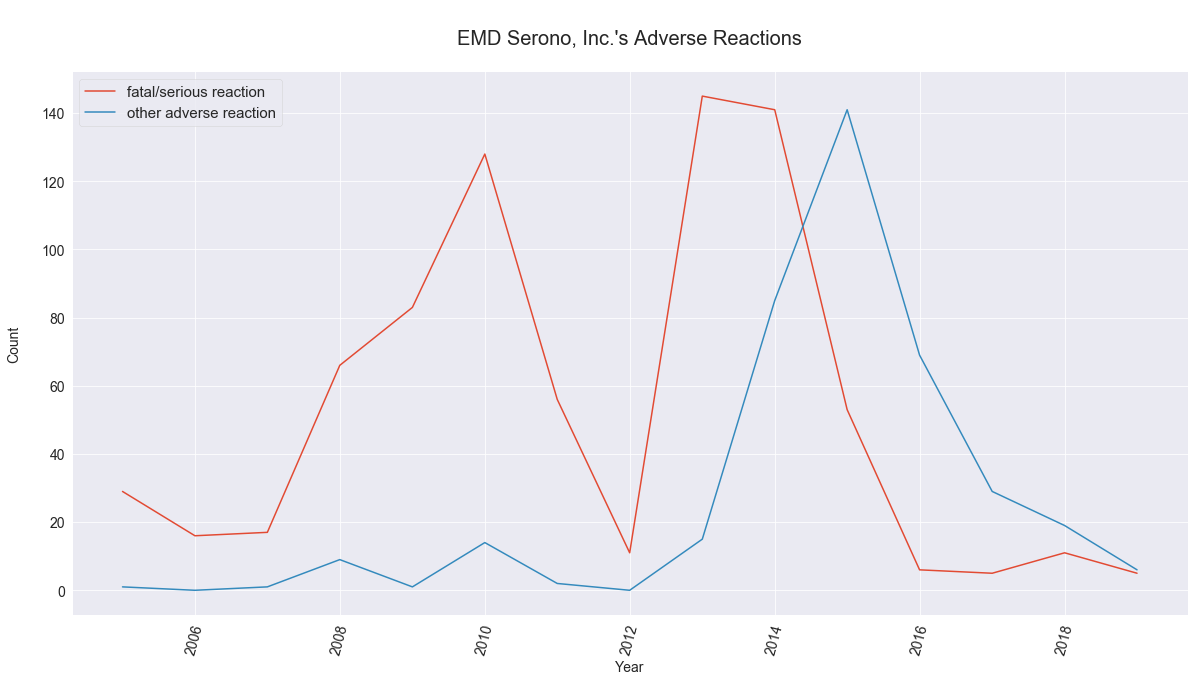

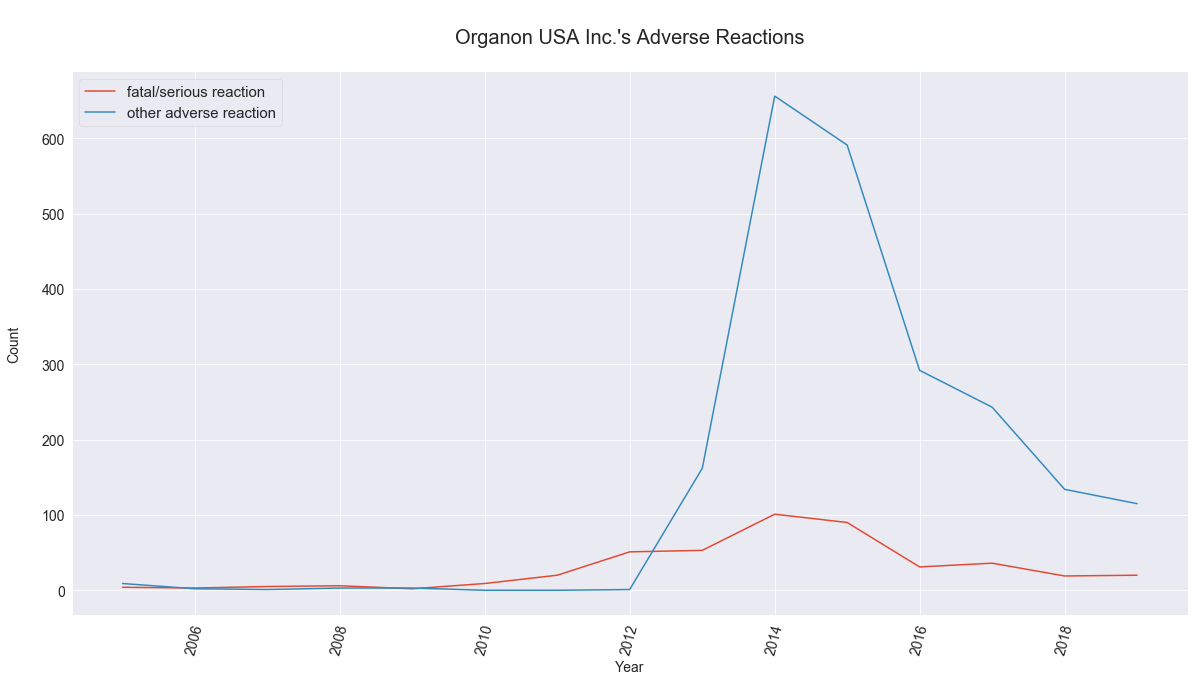

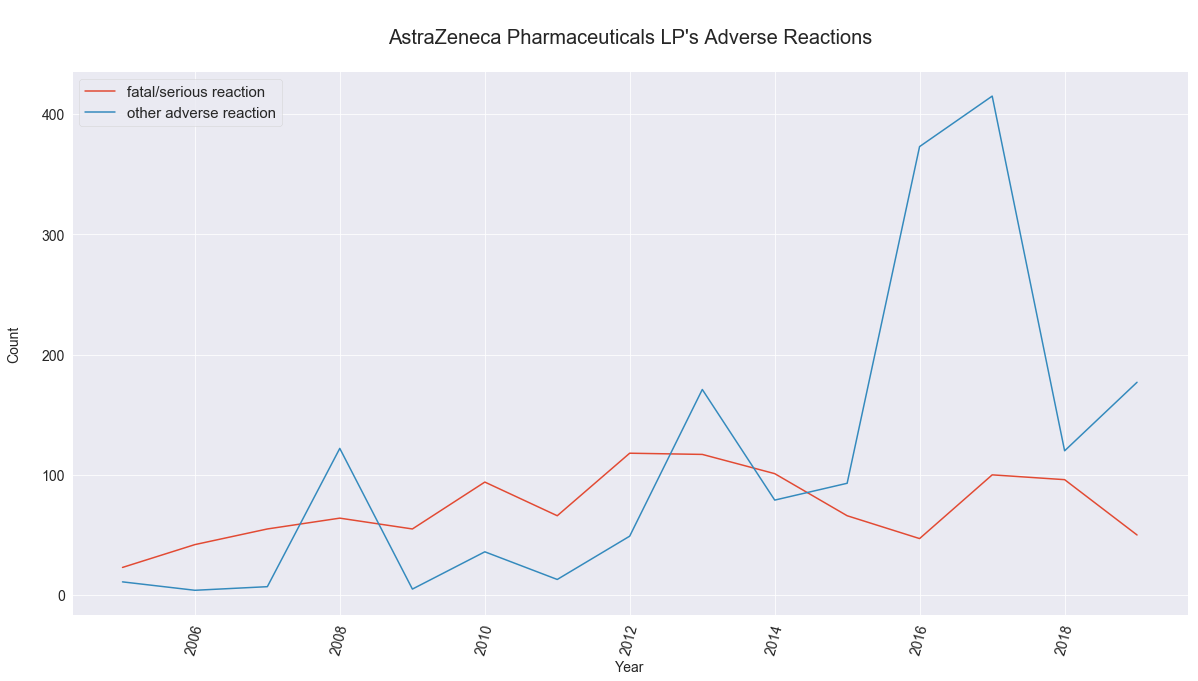

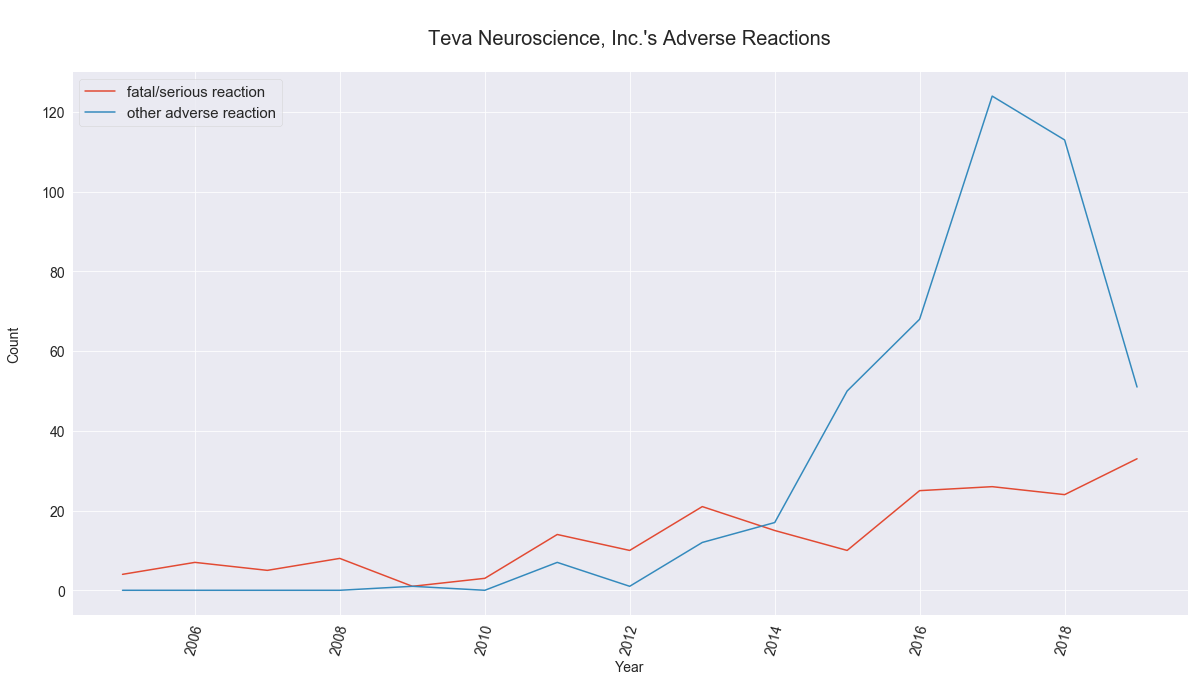

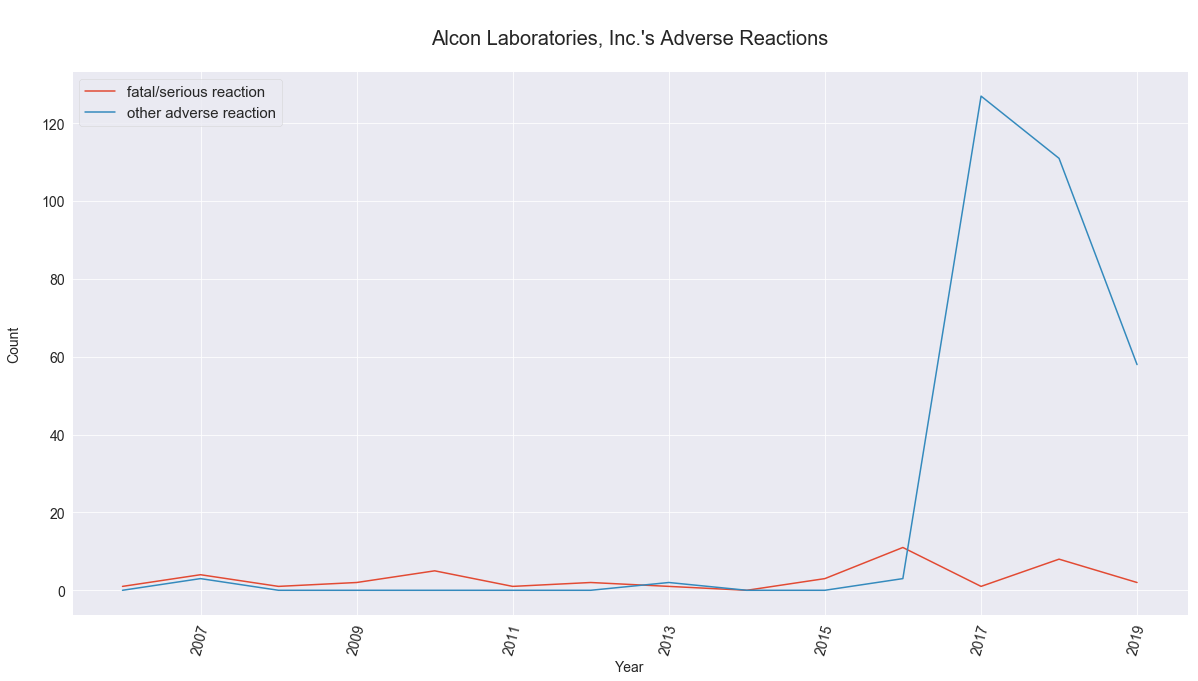

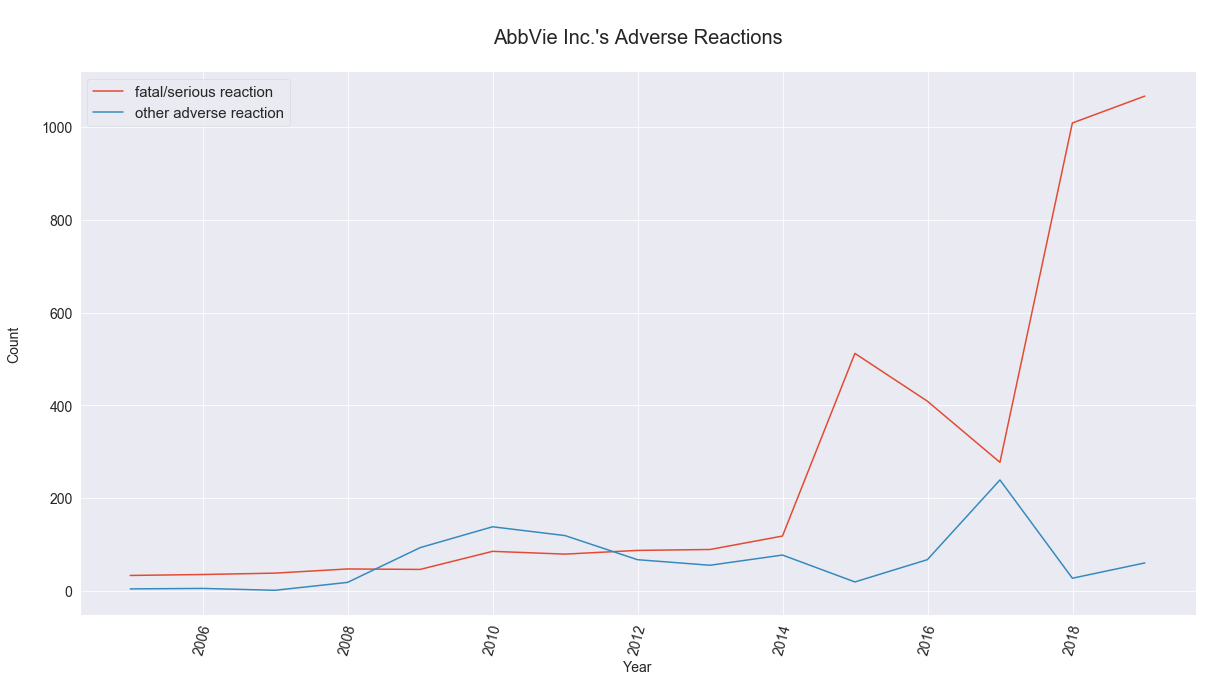

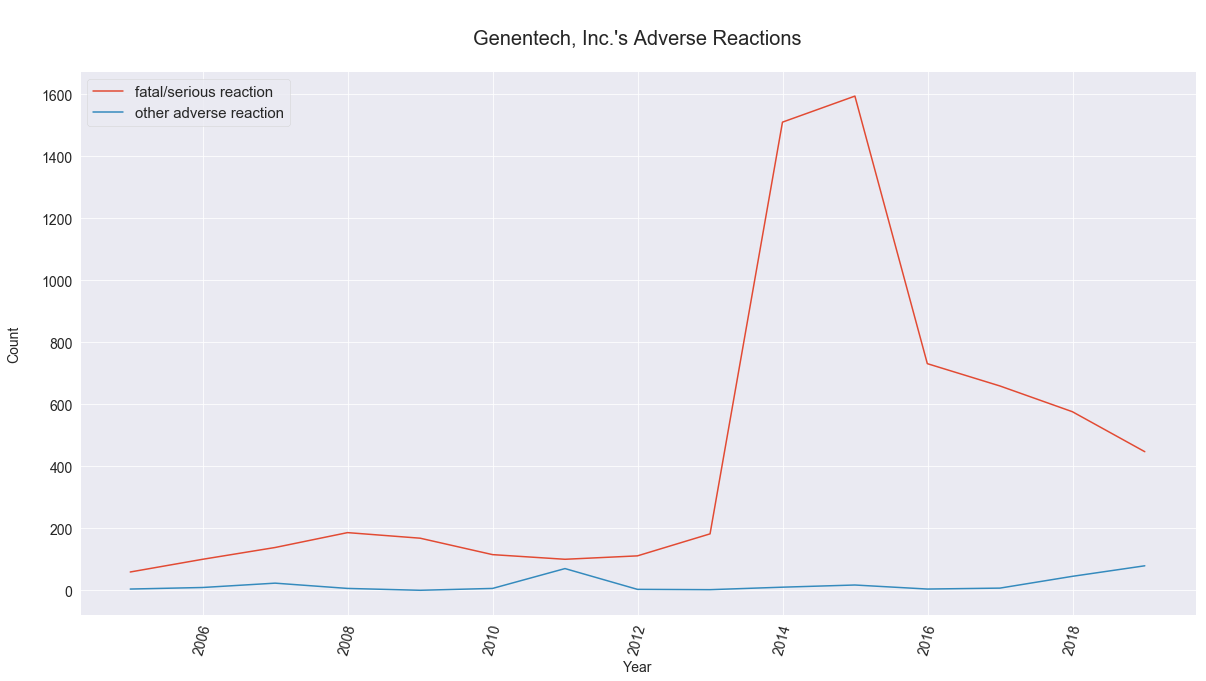

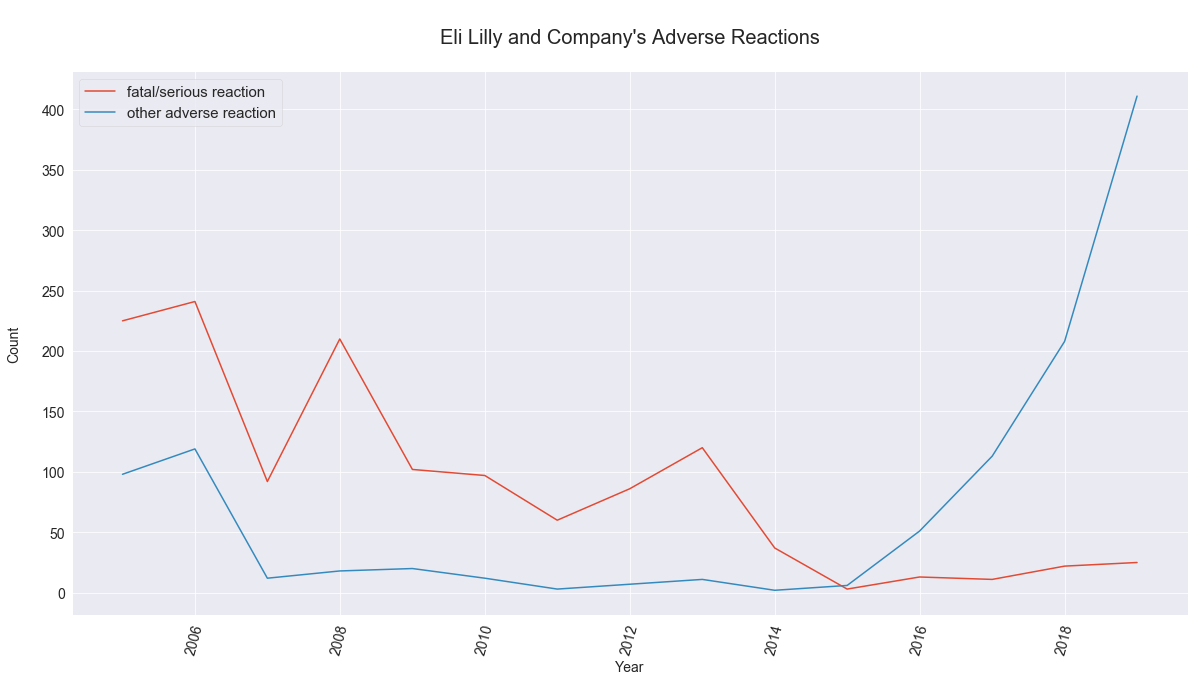

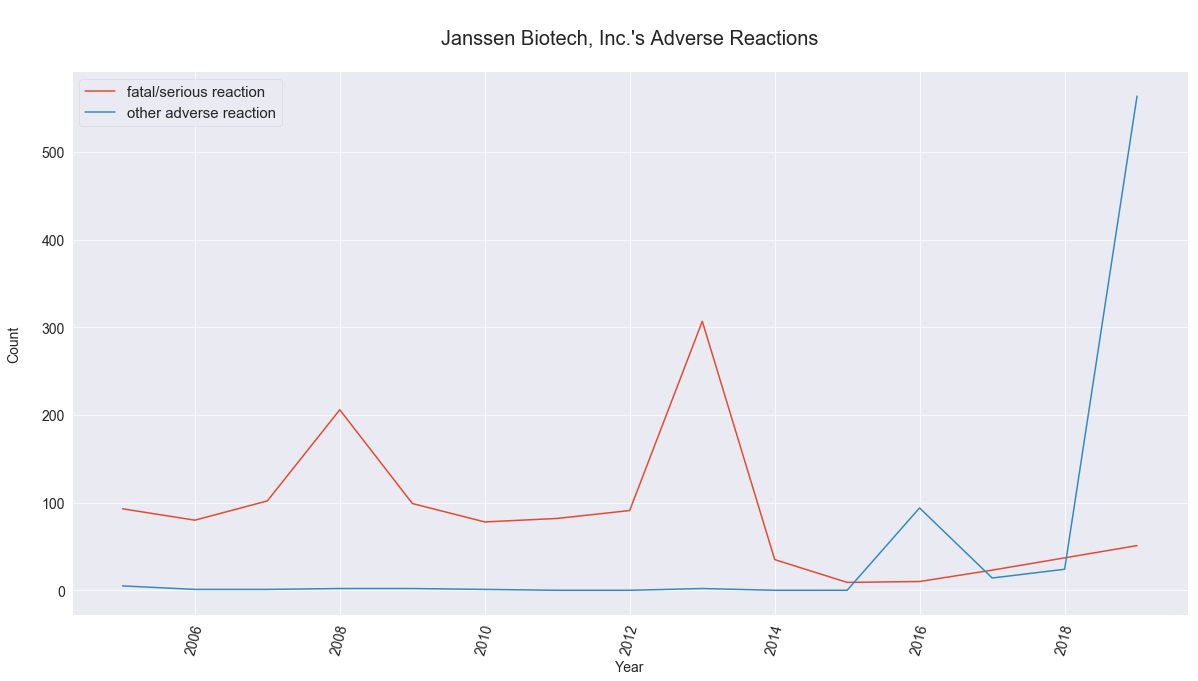

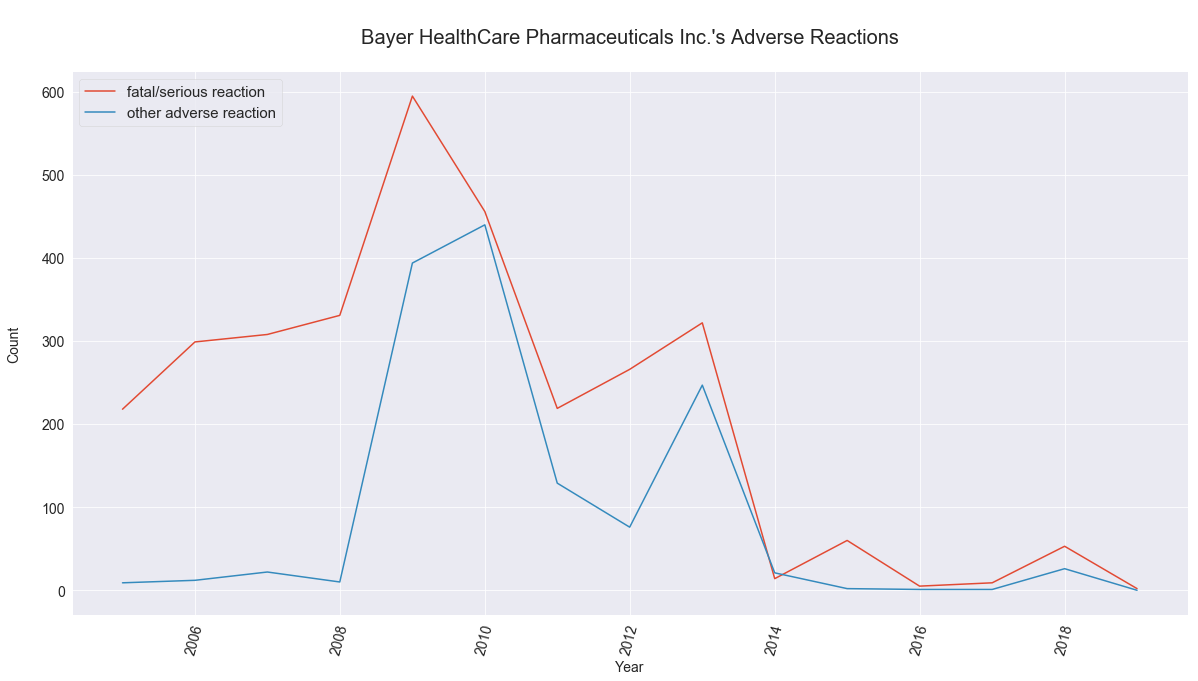

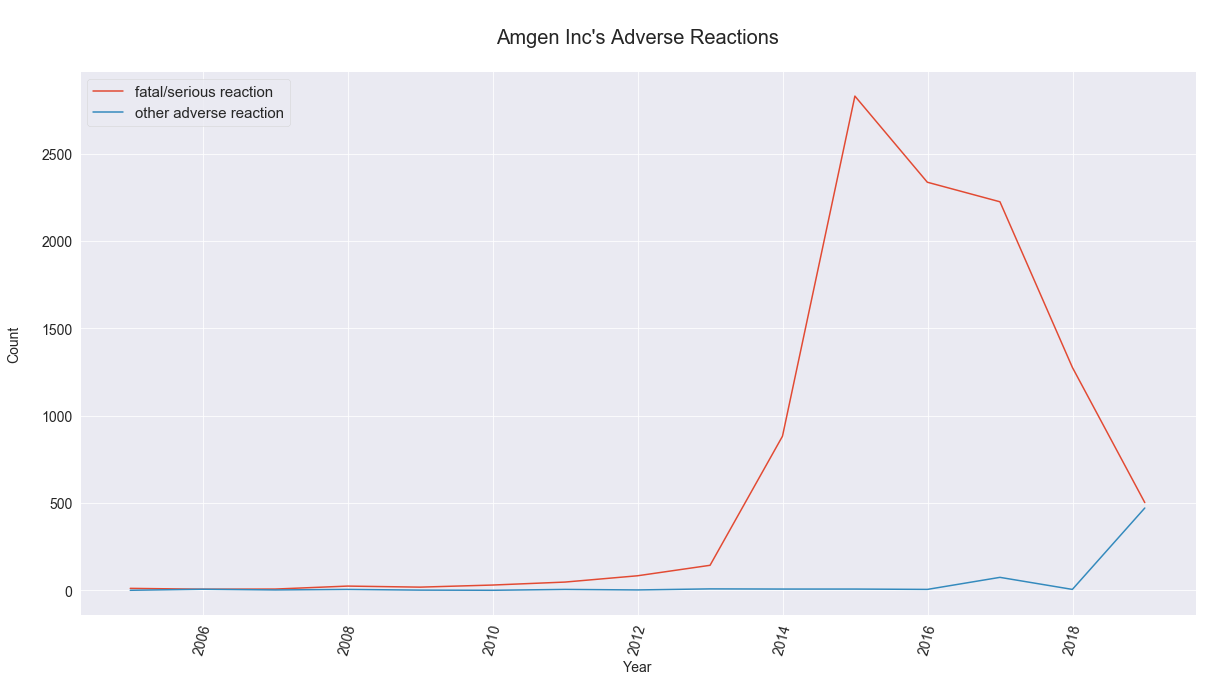

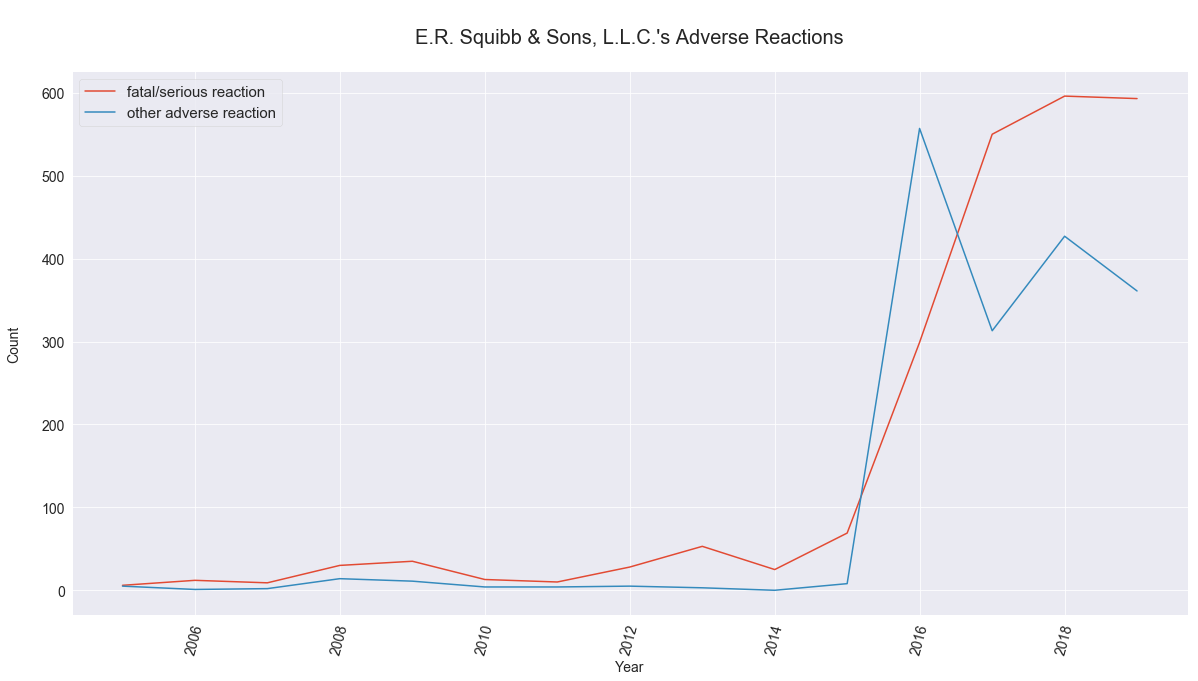

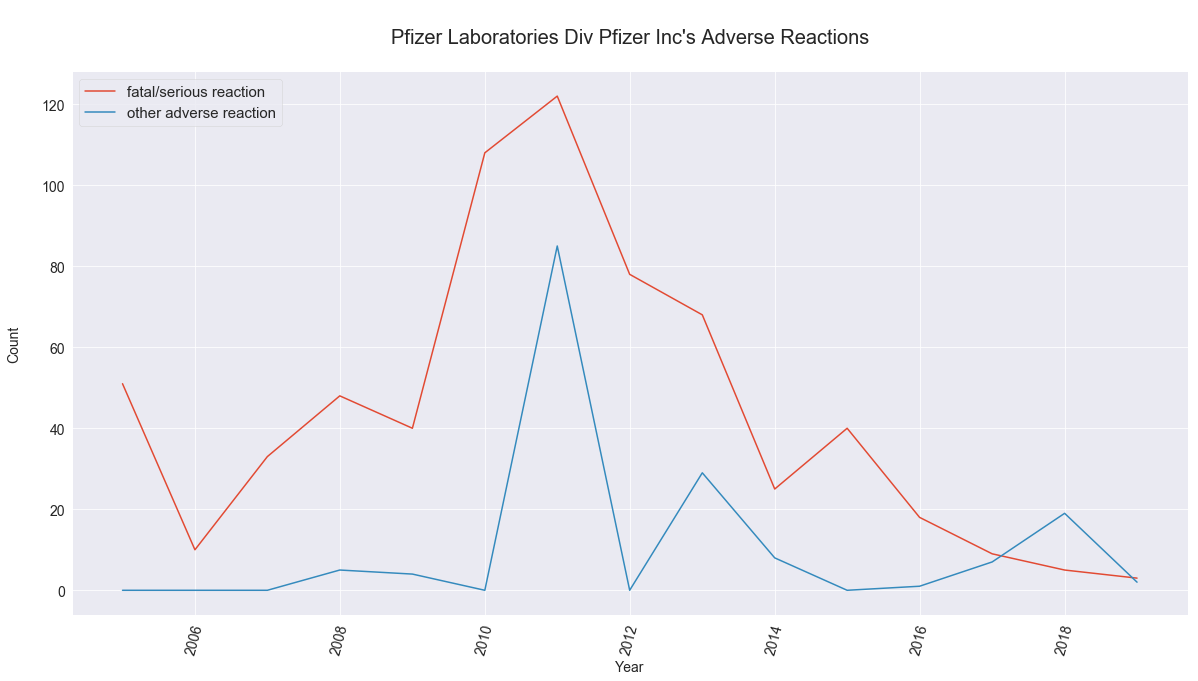

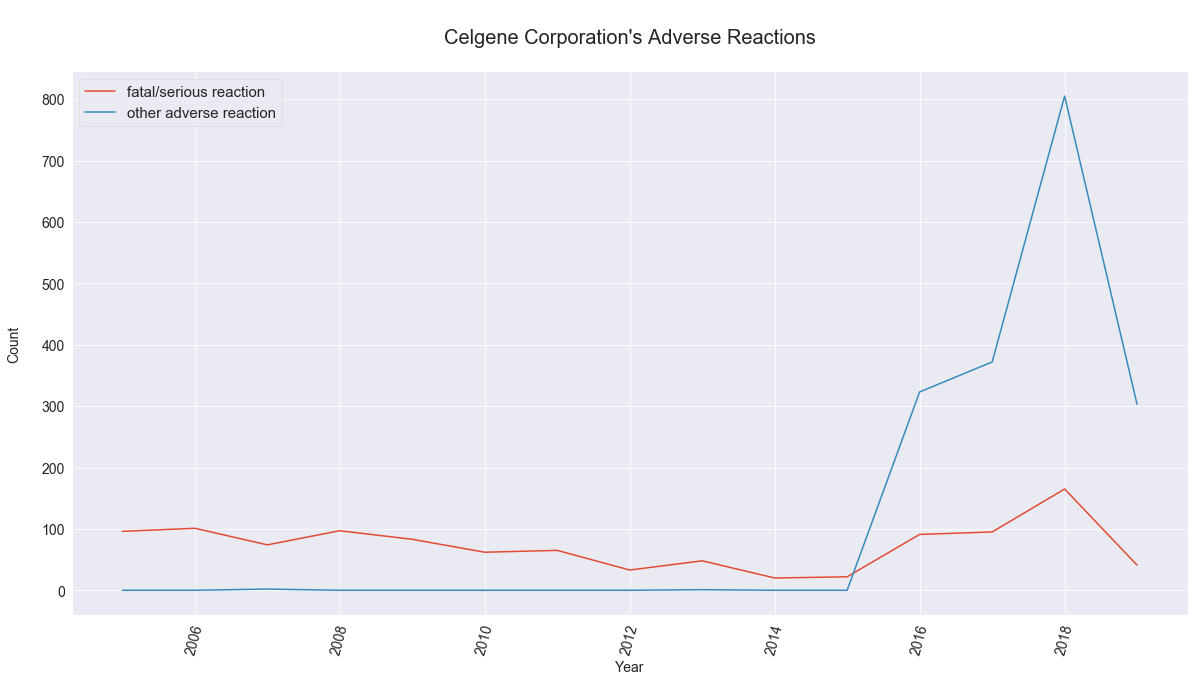

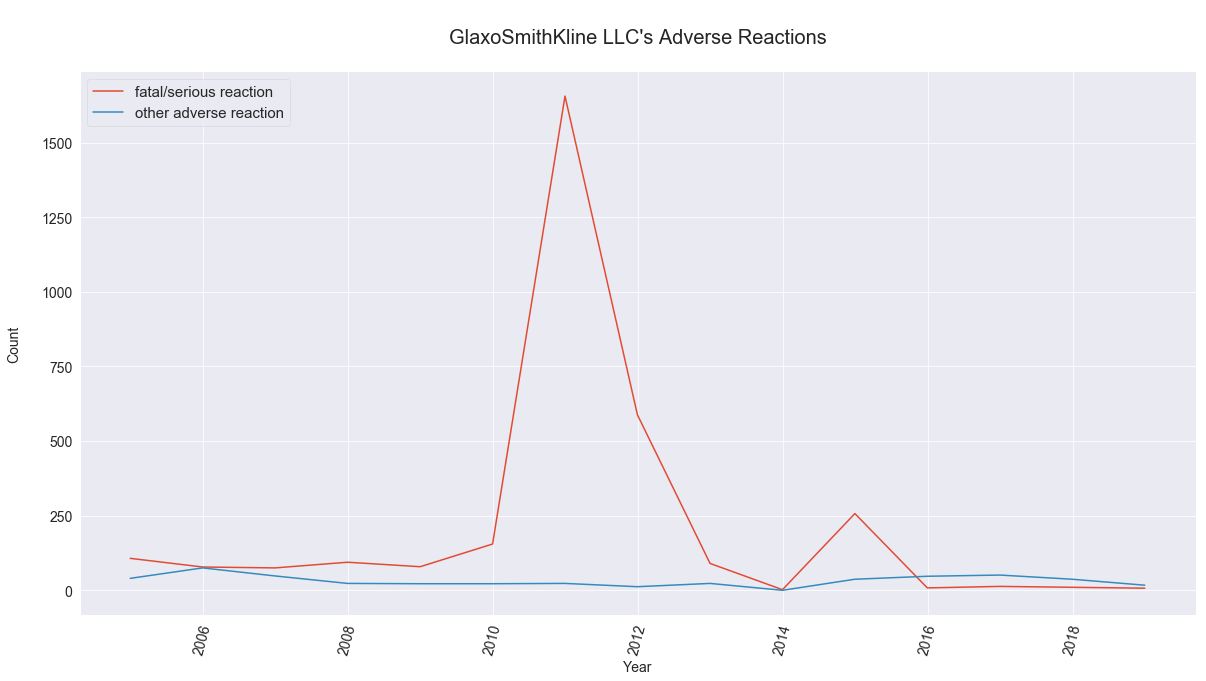

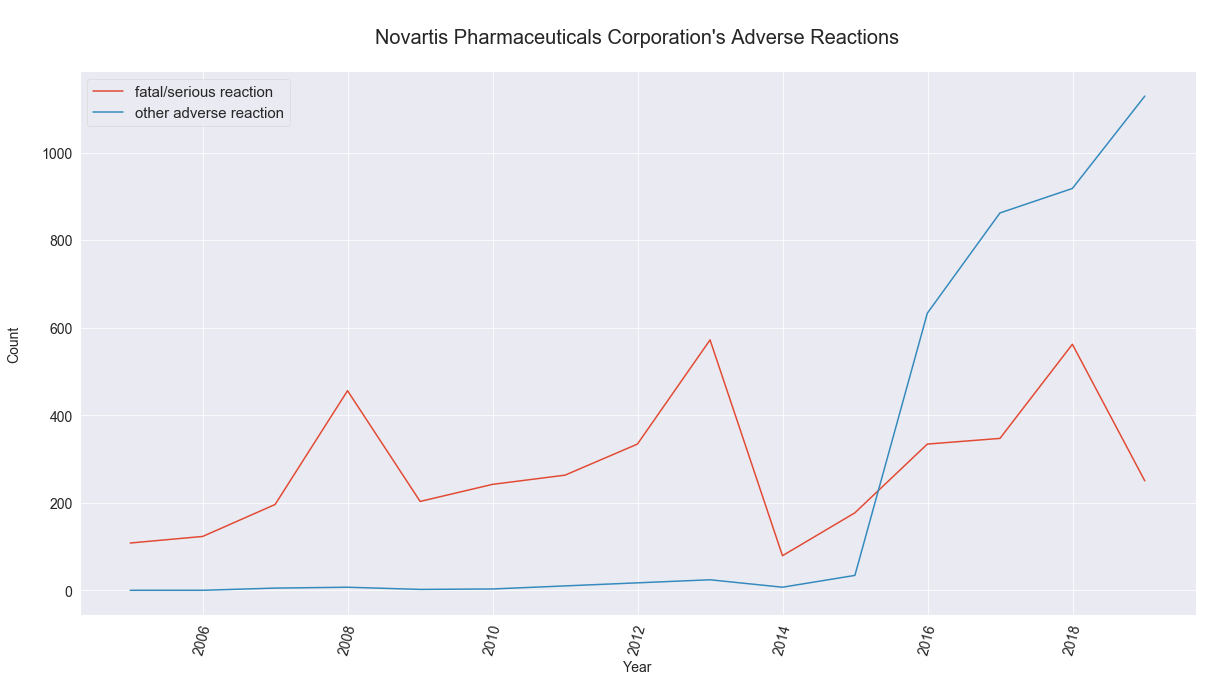

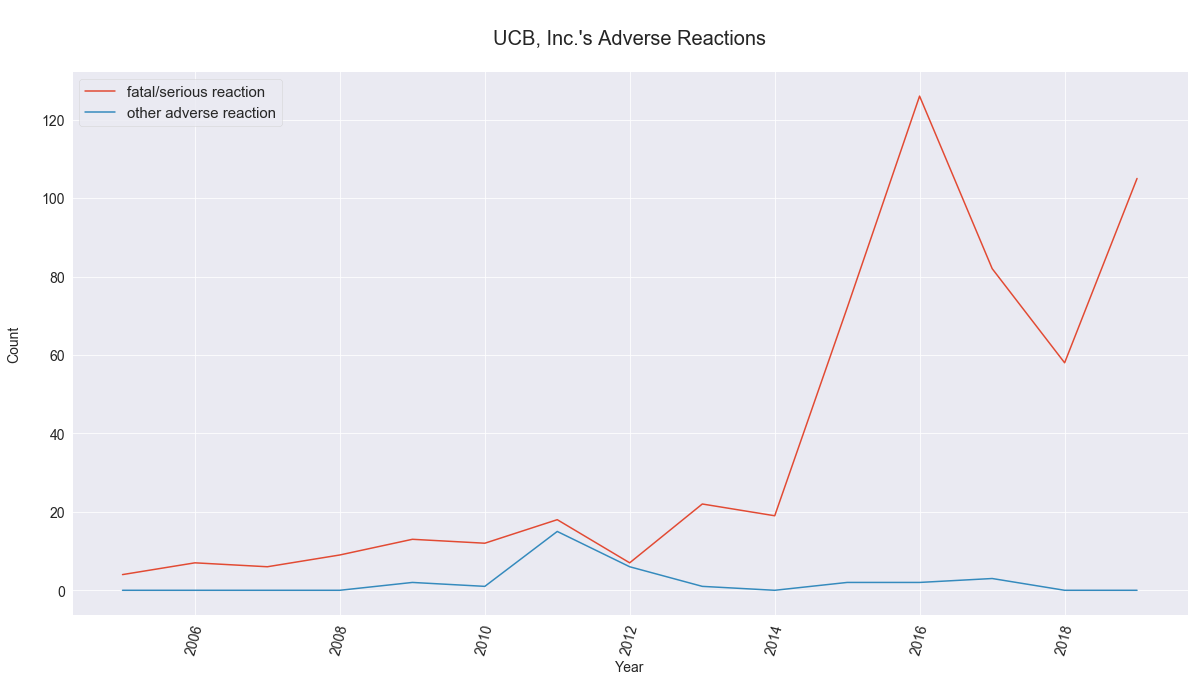

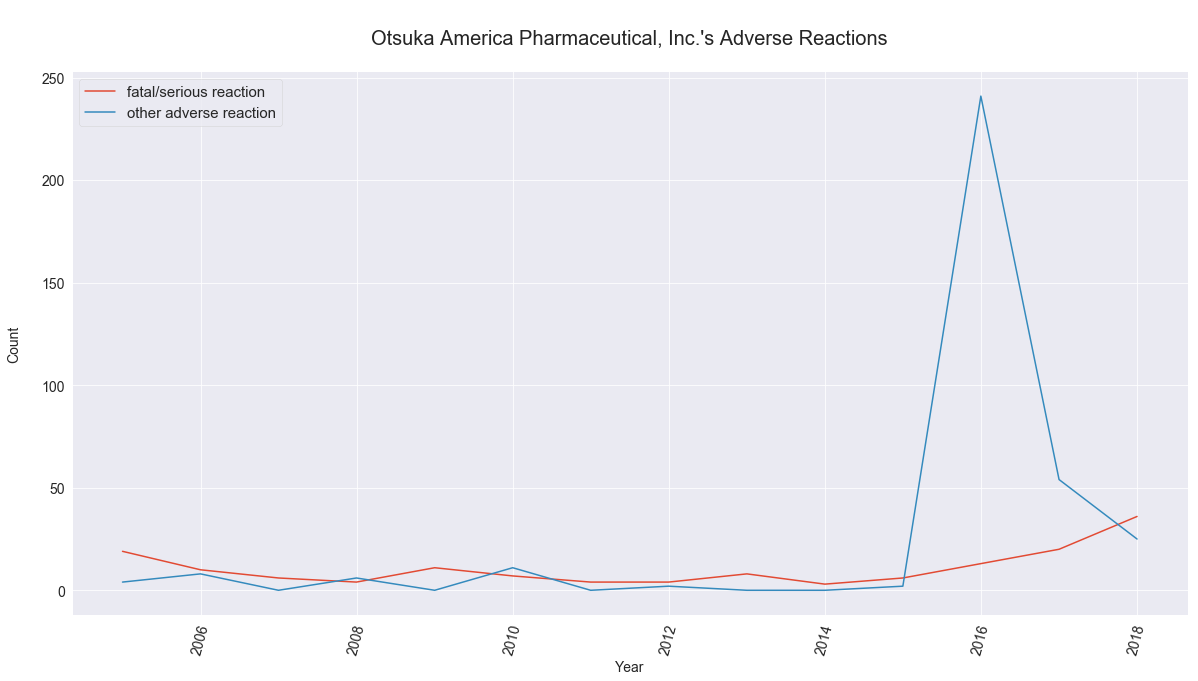

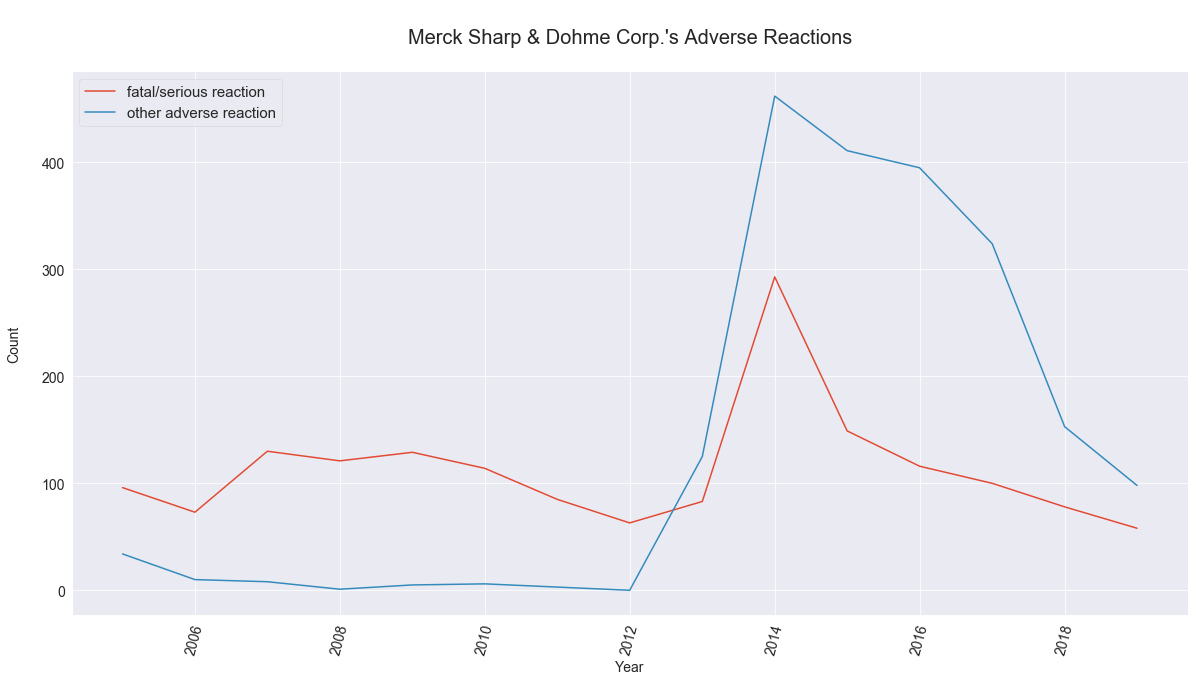

In [31]:
for company in top_company_names:
    df = together_companies[together_companies['company'] == company]
    df = df[df.index.map(lambda x: x < dt.datetime(2019, 1, 1))]
    df = df.groupby(pd.Grouper(freq="Y")).sum()
    plt.figure(figsize = (20,10))
    sns.lineplot(x = df.index, y = df.serious_obs.values)
    sns.lineplot(x = df.index, y = df['non-serious_obs'].values)
    plt.title(f'\n{company}\'s Adverse Reactions\n', fontsize = 20)
    plt.xlabel('Year', fontsize = 14)
    plt.xticks(fontsize = 14, rotation = 75)
    plt.yticks(fontsize = 14)
    plt.ylabel('Count\n', fontsize = 14)
    plt.legend(['fatal/serious reaction', 'other adverse reaction'], fontsize = 15, loc = 2)
    plt.savefig(f'images/each_company/{company}.png')

# Looking at adverse reactions by active substance

##### Question: can we predict the likelihood that GIVEN 1. you're taking some medication and 2. you have an adverse reaction, PROBABILITY that your adverse reaction will be fatal/life-altering 

In [32]:
data.activesubstancename.shape

(451836,)

In [ ]:
drug_list = []
for substances in data['activesubstancename']:
    try:
        [drug_list.append(x) for x in substances]
    except:
        continue

In [ ]:
len(set(drug_list))/len(drug_list)*100

### Does the number of medications your on predict the seriousness of your outcome
also, remember to look at outcomes

In [ ]:
medicine_data = data

In [ ]:
medicine_data = medicine_data[~medicine_data['activesubstancename'].isna()]

In [ ]:
medicine_data.head()

In [ ]:
patient_length = []
for substances in medicine_data['activesubstancename']:
    try:
        patient_length.append(len(substances))
    except:
        patient_length.append(np.nan)

In [ ]:
medicine_data['number_of_active_ingredients'] = patient_length

In [ ]:
medicines_grouped = medicine_data.groupby(['number_of_active_ingredients', 'serious']).size()
medicines_grouped = medicines_grouped.reset_index()
medicines_grouped = medicines_grouped.rename(columns={0: "observations"})
medicines_grouped['transformed_observations'] = np.log(medicines_grouped['observations'])

In [ ]:
plt.figure(figsize =(16,6))
sns.barplot(x = 'number_of_active_ingredients', y = 'transformed_observations', hue = 'serious', data = medicines_grouped[:30])

In [ ]:
plt.figure(figsize = (14,8))
sns.scatterplot(x = 'number_of_active_ingredients', y = 'observations', data = medicines_grouped[medicines_grouped['serious'] == '1'])
sns.scatterplot(x = 'number_of_active_ingredients', y = 'observations', data = medicines_grouped[medicines_grouped['serious'] == '2'])  
plt.ylim(-1,20000)

In [ ]:
medicines_grouped_serious = medicines_grouped[medicines_grouped['serious'] == '2']
medicines_grouped_not_serious = medicines_grouped[medicines_grouped['serious'] == '1']  
medicines_grouped_serious = medicines_grouped_serious.drop(columns = ['transformed_observations', 'serious'])
medicines_grouped_not_serious  = medicines_grouped_not_serious.drop(columns = ['transformed_observations', 'serious'])


In [ ]:
medicines_difference = medicines_grouped_not_serious.merge(medicines_grouped_serious, on = 'number_of_active_ingredients')

In [ ]:
medicines_difference['difference'] = medicines_difference['observations_x']/(medicines_difference['observations_y']+medicines_difference['observations_x'])*100
medicines_difference['difference_transform'] = (medicines_difference['difference']) - (1/100)*(medicines_difference['difference'])**(2)

In [ ]:
plt.figure(figsize = (14,7))
sns.scatterplot(x = medicines_difference.index, y = medicines_difference['difference'])

In [ ]:
plt.figure(figsize = (14,7))
sns.scatterplot(x = medicines_difference.index, y = medicines_difference['difference_transform'])

# Looking at adverse reactions over time (Time Series Analysis)

#### A. Collect Data in Two Categories: Serious1 and Serious2

In [188]:
a = data.reset_index()
b = a.dropna()
c = b[b.company.apply(lambda x: True if x[0] == 'Immunex Corporation' else False)].index
d = a[a.index.map(lambda x: x not in c)]
d = d.set_index('receivedate')
ser1mod = pd.Series(d[d['serious'] == '1'].groupby(pd.Grouper(freq="M")).size())
ser2mod = pd.Series(d[d['serious'] == '2'].groupby(pd.Grouper(freq="M")).size())

serious1 = pd.Series(data[data['serious'] == '1'].groupby(pd.Grouper(freq="M")).size())
serious2 = pd.Series(data[data['serious'] == '2'].groupby(pd.Grouper(freq="M")).size())

In [ ]:
# serious1x = serious1.index
# serious1y = serious1.values
# serious2x = serious2.index
# serious2y = serious2.values

# tscv = TimeSeriesSplit(n_splits=5)
# for train_index, test_index in tscv.split(serious1x):
#     #print("TRAIN:", train_index, "TEST:", test_index)
#     serious1x_train, serious1x_test = serious1x[train_index], serious1x[test_index]
#     serious1y_train, serious1y_test = serious1y[train_index], serious1y[test_index]

# for train_index, test_index in tscv.split(serious2x):
#     #print("TRAIN:", train_index, "TEST:", test_index)
#     serious2x_train, serious2x_test = serious2x[train_index], serious2x[test_index]
#     serious2y_train, serious2y_test = serious2y[train_index], serious2y[test_index]

# serious1_train = pd.DataFrame(np.asarray([serious1x_train, serious1y_train]).T, columns = ['Date', 'Value']).set_index('Date')
# serious1_test = pd.DataFrame(np.asarray([serious1x_test, serious1y_test]).T, columns = ['Date', 'Value']).set_index('Date')
# serious2_train = pd.DataFrame(np.asarray([serious2x_train, serious2y_train]).T, columns = ['Date', 'Value']).set_index('Date')
# serious2_test = pd.DataFrame(np.asarray([serious2x_test, serious2y_test]).T, columns = ['Date', 'Value']).set_index('Date')

#### B. Plot the occurences over time

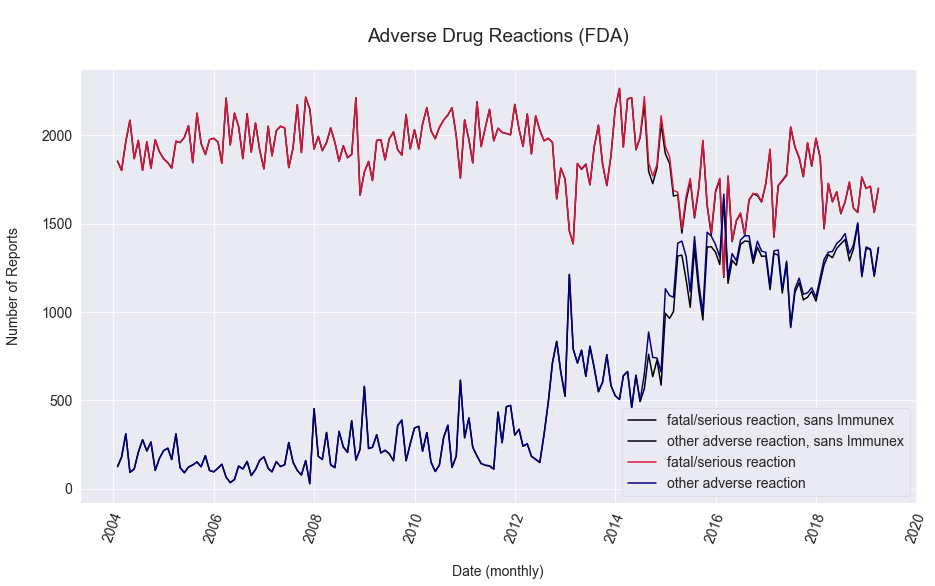

In [192]:
plt.figure(figsize = (15,8))

sns.lineplot(data = ser1mod, color = 'black', label = 'fatal/serious reaction, sans Immunex')
sns.lineplot(data = ser2mod, color =  'black', label = 'other adverse reaction, sans Immunex')
sns.lineplot(data = serious1, color = 'crimson', label = 'fatal/serious reaction')
sns.lineplot(data = serious2, color =  'navy', label = 'other adverse reaction')
plt.xlabel('\nDate (monthly)', fontsize = 14)
plt.ylabel('Number of Reports\n', fontsize = 14)
plt.xticks(fontsize = 14, rotation = 70)
plt.yticks(fontsize = 14)
plt.title('\nAdverse Drug Reactions (FDA)\n', fontsize = 19)
plt.legend(fontsize = 14, loc = 4)
plt.savefig('images/adverse_drug_reactions.png', bbox_inches = "tight")
plt.show()

#### C. Find the **trend**, **seasonality**, and **residuals** for serious1 and serious2

**serious1**

<Figure size 432x288 with 0 Axes>

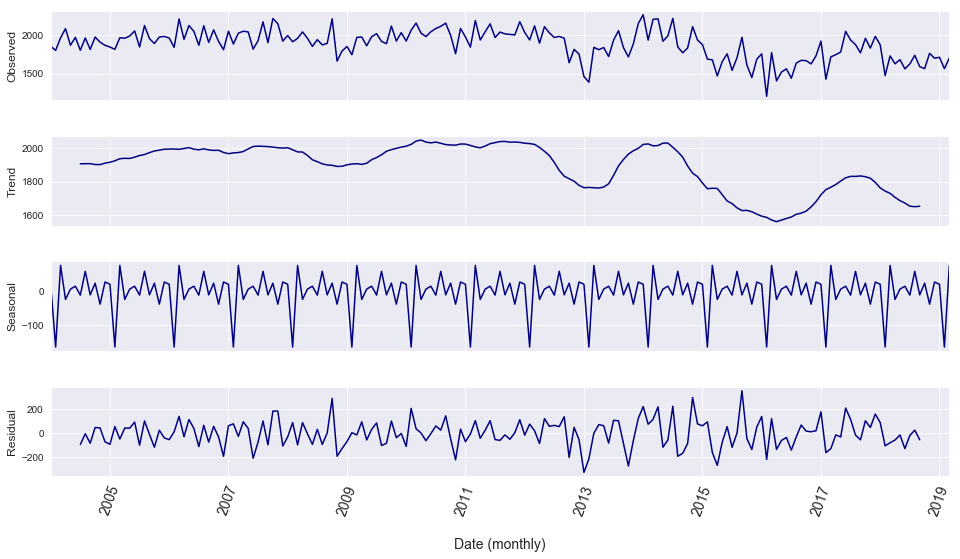

In [54]:
decomposition = seasonal_decompose(serious1, freq = 12)
fig = plt.figure()
fig = decomposition.plot()
plt.xticks(fontsize = 14, rotation = 70)
plt.xlabel('\nDate (monthly)', fontsize = 14)
for ax in plt.gcf().axes:
    ax.get_lines()[0].set_color('navy')
fig.set_size_inches(15, 8)
plt.show()

**serious2**

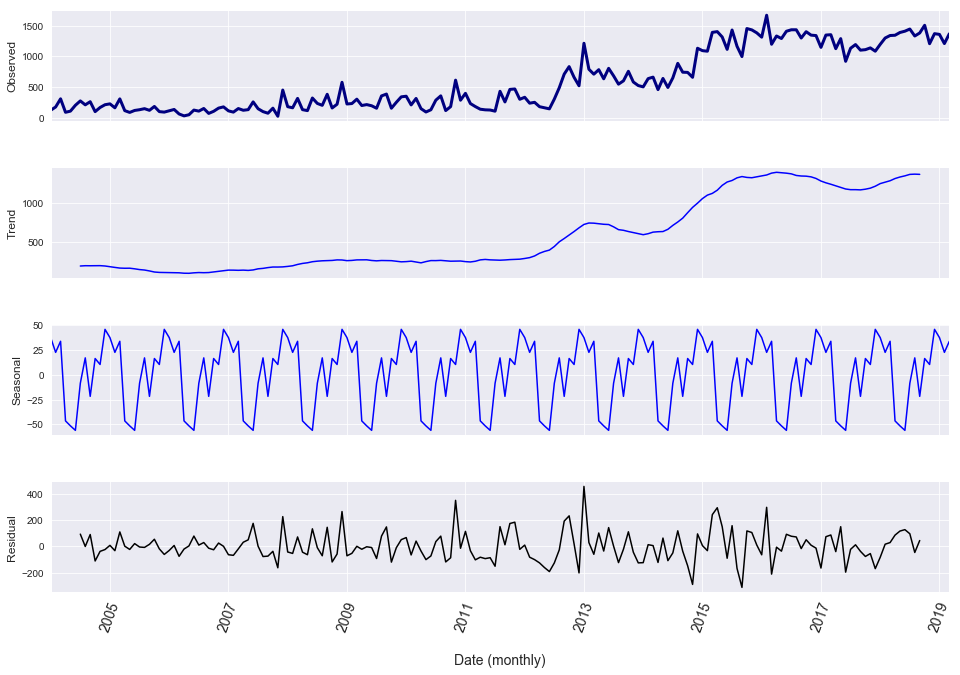

In [55]:
decomposition = seasonal_decompose(serious2, freq = 12)
fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.xticks(fontsize = 14, rotation = 70)
plt.xlabel('\nDate (monthly)', fontsize = 14)
for i, ax in enumerate(plt.gcf().axes):
    if i == 0:
        ax.get_lines()[0].set_color('navy')
        ax.get_lines()[0].set_linewidth(3)
    elif i in [1,2]:
        ax.get_lines()[0].set_color('blue')
    else:
        ax.get_lines()[0].set_color('black')

plt.savefig('images/decomposition.png')
plt.show()

#### D. Make data stationarity (i.e. detrend the data)

In [56]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:].values, color='blue',label='Original')
    mean = plt.plot(rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

**serious1**

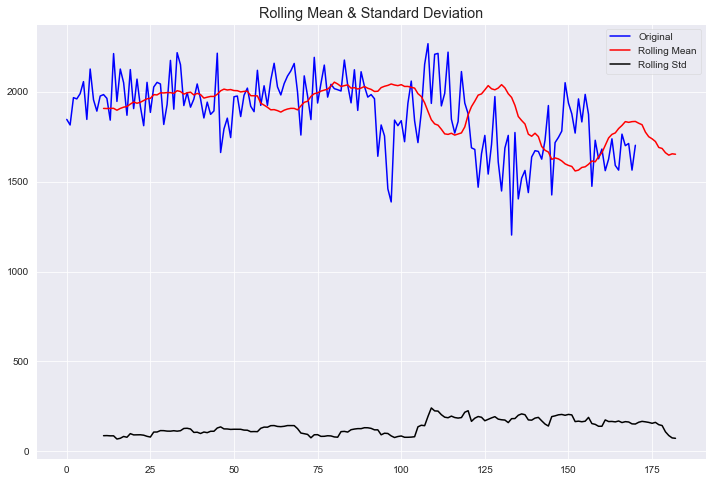

Results of Dickey-Fuller Test:
Test Statistic                  -2.382776
p-value                          0.146657
#Lags Used                      14.000000
Number of Observations Used    168.000000
Critical Value (1%)             -3.469886
Critical Value (5%)             -2.878903
Critical Value (10%)            -2.576027
dtype: float64


In [60]:
test_stationarity(serious1, 12)

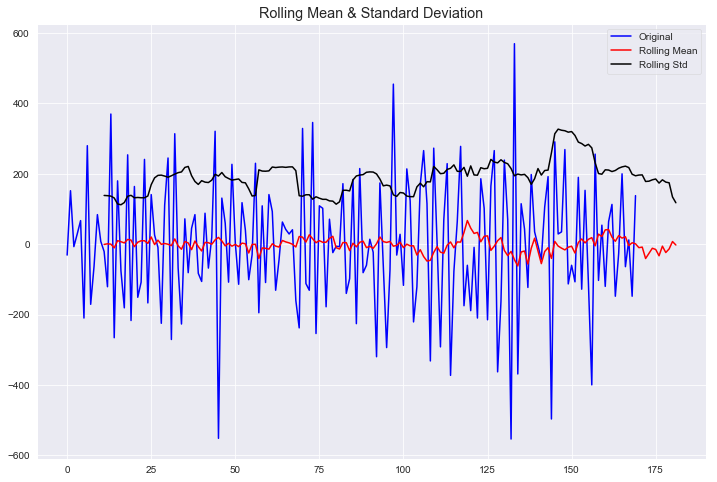

Results of Dickey-Fuller Test:
Test Statistic                  -4.236285
p-value                          0.000572
#Lags Used                      14.000000
Number of Observations Used    167.000000
Critical Value (1%)             -3.470126
Critical Value (5%)             -2.879008
Critical Value (10%)            -2.576083
dtype: float64


In [58]:
test_stationarity(serious1.diff(1).dropna(inplace = False), 12)

**serious2**

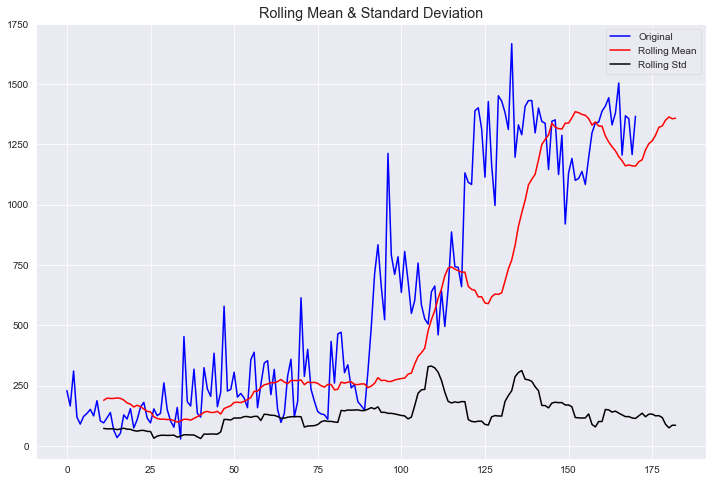

Results of Dickey-Fuller Test:
Test Statistic                  -0.524917
p-value                          0.887062
#Lags Used                       2.000000
Number of Observations Used    180.000000
Critical Value (1%)             -3.467211
Critical Value (5%)             -2.877735
Critical Value (10%)            -2.575403
dtype: float64


<Figure size 432x288 with 0 Axes>

In [202]:
test_stationarity(serious2, 12)
plt.savefig('stationarity1.png', bbox_inches = "tight")

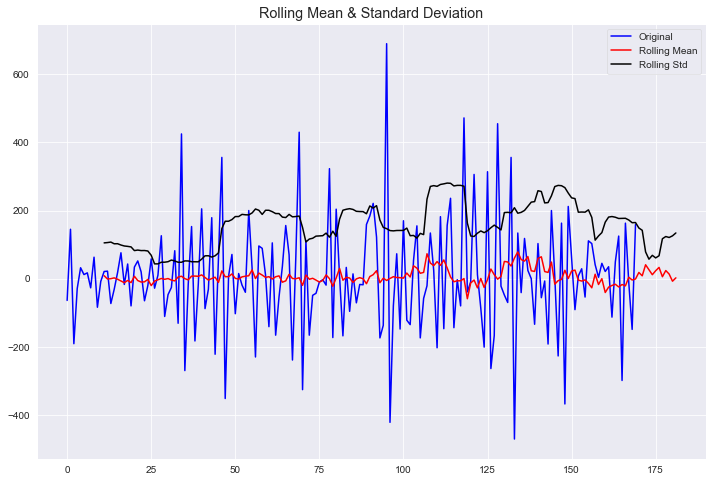

Results of Dickey-Fuller Test:
Test Statistic                -1.648281e+01
p-value                        2.229063e-29
#Lags Used                     1.000000e+00
Number of Observations Used    1.800000e+02
Critical Value (1%)           -3.467211e+00
Critical Value (5%)           -2.877735e+00
Critical Value (10%)          -2.575403e+00
dtype: float64


<Figure size 432x288 with 0 Axes>

In [203]:
test_stationarity(serious2.diff(1).dropna(inplace = False), 12)
plt.savefig('stationarity2.png', bbox_inches = "tight")

#### E. Figure out what kind of model we need: autoregressive? moving average?

**serious1**

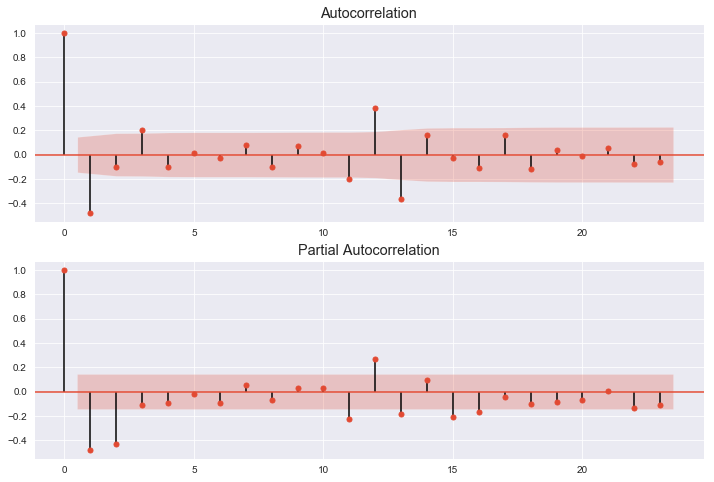

In [63]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(serious1.diff(1).dropna(inplace = False).dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(serious1.diff(1).dropna(inplace = False).dropna(), ax=ax2)

**serious2**

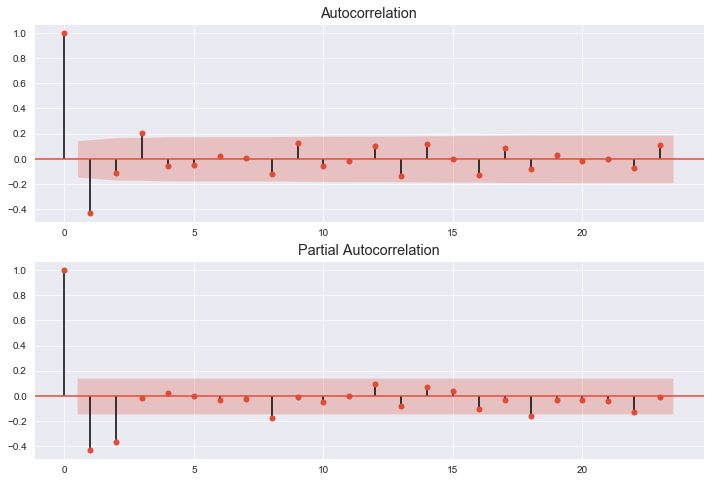

In [204]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(serious2.diff(1).dropna(inplace = False), ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(serious2.diff(1).dropna(inplace = False), ax=ax2)
plt.savefig('correlations.png', bbox_inches = "tight")

#### F. Model estimates based on previous information

**serious2**

In [210]:
mod = sm.tsa.statespace.SARIMAX(serious2[:165], order=(0,1,1), seasonal_order=(0,1,1,24))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  165
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 24)   Log Likelihood                -916.774
Date:                            Thu, 21 Nov 2019   AIC                           1839.548
Time:                                    14:19:26   BIC                           1848.373
Sample:                                01-31-2004   HQIC                          1843.134
                                     - 09-30-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5954      0.059    -10.150      0.000      -0.710      -0.480
ma.S.L24      -0.9888      2.735     -0.362      0.718      -6.349       4.371
sigma2      2.085e+04    5.6e+04      0.373      0.710   -8.88e+04    1.31e+05
===================================================================================
Ljung-Box (Q):                       36.39   Jarque-Bera (JB):                25.31
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               3.47   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**serious1**

In [211]:
mod2 = sm.tsa.statespace.SARIMAX(serious1[:165], order=(0,1,1), seasonal_order=(0,1,1,24))
res2 = mod2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  165
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 24)   Log Likelihood                -916.488
Date:                            Thu, 21 Nov 2019   AIC                           1838.976
Time:                                    14:19:30   BIC                           1847.801
Sample:                                01-31-2004   HQIC                          1842.562
                                     - 09-30-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6818      0.062    -11.043      0.000      -0.803      -0.561
ma.S.L24      -0.8006      0.186     -4.306      0.000      -1.165      -0.436
sigma2      2.407e+04   3497.935      6.882      0.000    1.72e+04    3.09e+04
===================================================================================
Ljung-Box (Q):                       64.69   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.01   Prob(JB):                         0.74
Heteroskedasticity (H):               2.72   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### G. Forecast using generated models

In [70]:
serious2 = pd.DataFrame(serious2, columns = ['values'])
serious1 = pd.DataFrame(serious1, columns = ['values'])

In [71]:
serious1.shape

(183, 1)

In [72]:
serious1['forecast'] = res2.predict(start = 180, end = 183, dynamic = False)

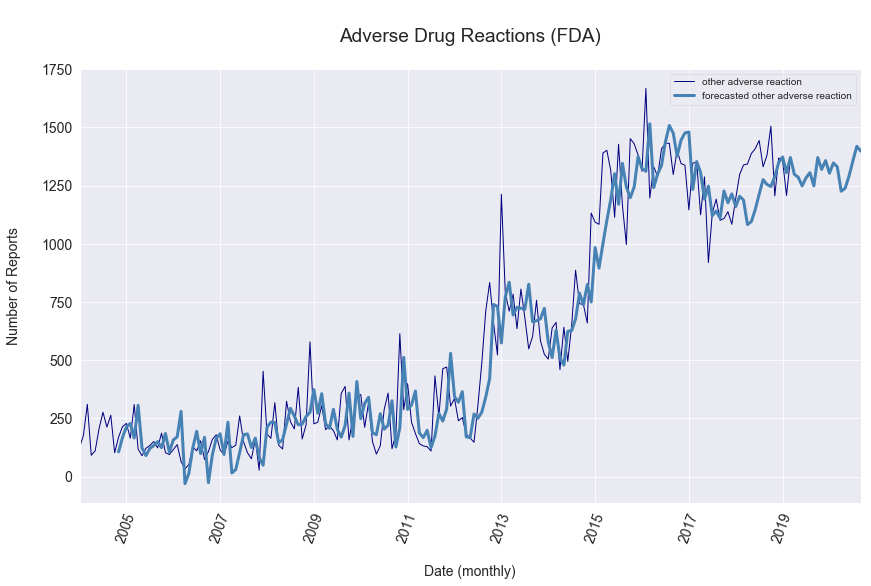

In [209]:

#res2.predict(start = 183, end = 250, dynamic = False).plot(color = 'firebrick', lw = 3)

#serious1.plot.line(color= 'crimson', lw = 1)

serious2.plot.line(color = 'navy', lw = 1, figsize = (14,8), label = 'other adverse reaction')
res.predict(start = 10, end = 200, dynamic= False).plot(color = 'steelblue', lw = 3, label = 'forecasted other adverse reaction')


plt.xlabel('\nDate (monthly)', fontsize = 14)
plt.ylabel('Number of Reports\n', fontsize = 14)
plt.xticks(fontsize = 14, rotation = 70)
plt.yticks(fontsize = 14)
plt.title('\nAdverse Drug Reactions (FDA)\n', fontsize = 19)
plt.legend()
#plt.legend(['other adverse reaction', 'fatal/serious reaction', 'forecasted other adverse reaction', 'forecasted fatal/serious reaction'], fontsize = 13, loc = 4)
plt.savefig('images/adverse_drug_reactions_forecast1.png')
plt.show()


In [117]:
data[~data.company.isna()].company.apply(lambda x: True if x[0] == 'Immunex Corporation' else False).value_counts()

False    102689
True      20064
Name: company, dtype: int64

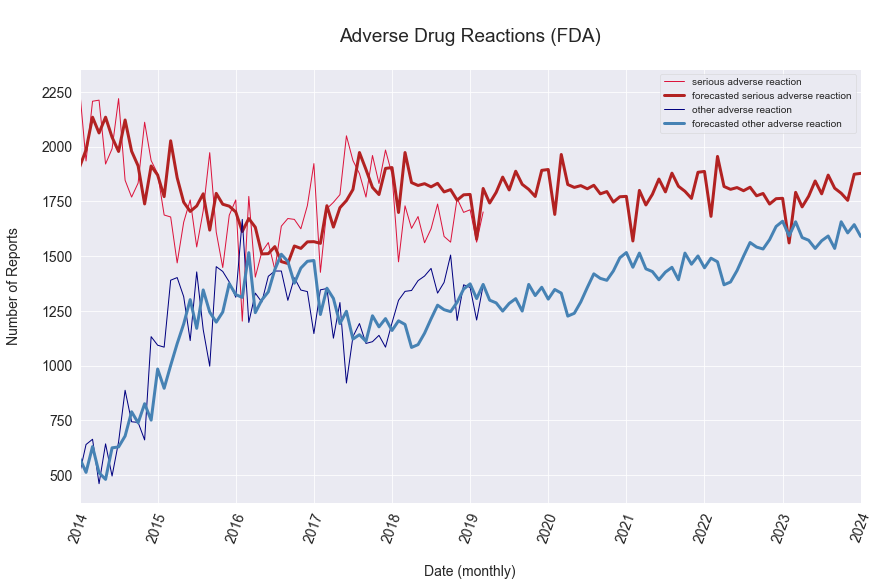

In [213]:
serious1[120:].plot.line(color = 'crimson', lw = 1, figsize = (14,8), label = 'serious adverse reaction')
res2.predict(start = 120, end = 240, dynamic= False).plot(color = 'firebrick', lw = 3, label = 'forecasted serious adverse reaction')

serious2[120:].plot.line(color = 'navy', lw = 1, figsize = (14,8), label = 'other adverse reaction')
res.predict(start = 120, end = 240, dynamic= False).plot(color = 'steelblue', lw = 3, label = 'forecasted other adverse reaction')


plt.xlabel('\nDate (monthly)', fontsize = 14)
plt.ylabel('Number of Reports\n', fontsize = 14)
plt.xticks(fontsize = 14, rotation = 70)
plt.yticks(fontsize = 14)
plt.title('\nAdverse Drug Reactions (FDA)\n', fontsize = 19)
plt.legend()
#plt.legend(['other adverse reaction', 'fatal/serious reaction', 'forecasted other adverse reaction', 'forecasted fatal/serious reaction'], fontsize = 13, loc = 4)
plt.savefig('images/adverse_drug_reactions_forecast2.png',  bbox_inches = "tight")
plt.show()

In [ ]:



serious2[140:].plot.line(color = 'navy', lw = 1, figsize = (14,8), label = 'other adverse reaction')
res.predict(start = 140, end = 240, dynamic= False).plot(color = 'steelblue', lw = 3, label = 'forecasted other adverse reaction')


plt.xlabel('\nDate (monthly)', fontsize = 14)
plt.ylabel('Number of Reports\n', fontsize = 14)
plt.xticks(fontsize = 14, rotation = 70)
plt.yticks(fontsize = 14)
plt.title('\nAdverse Drug Reactions (FDA)\n', fontsize = 19)
plt.legend()
#plt.legend(['other adverse reaction', 'fatal/serious reaction', 'forecasted other adverse reaction', 'forecasted fatal/serious reaction'], fontsize = 13, loc = 4)
plt.savefig('images/adverse_drug_reactions_forecast2.png',  bbox_inches = "tight")
plt.show()

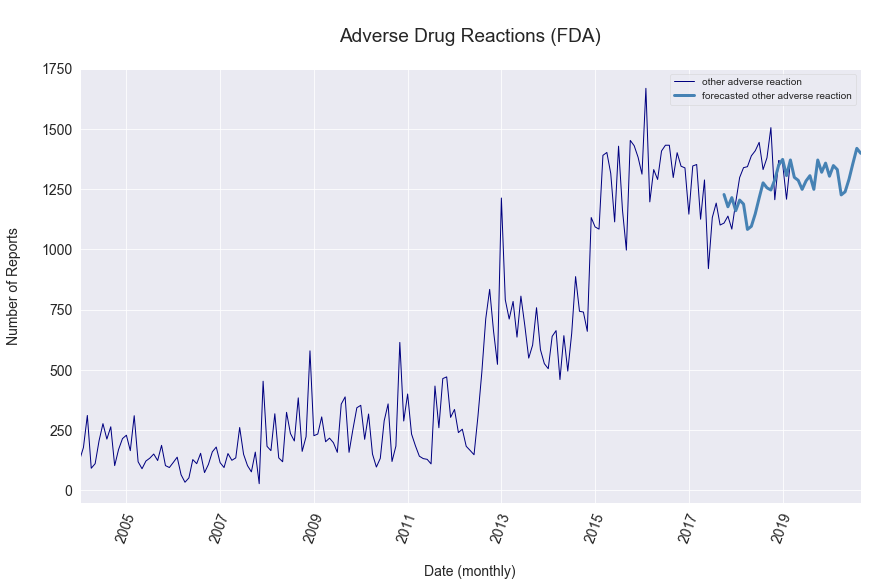

In [214]:

#res2.predict(start = 183, end = 250, dynamic = False).plot(color = 'firebrick', lw = 3)

#serious1.plot.line(color= 'crimson', lw = 1)

serious2.plot.line(color = 'navy', lw = 1, figsize = (14,8), label = 'other adverse reaction')
res.predict(start = 165, end = 200, dynamic= False).plot(color = 'steelblue', lw = 3, label = 'forecasted other adverse reaction')


plt.xlabel('\nDate (monthly)', fontsize = 14)
plt.ylabel('Number of Reports\n', fontsize = 14)
plt.xticks(fontsize = 14, rotation = 70)
plt.yticks(fontsize = 14)
plt.title('\nAdverse Drug Reactions (FDA)\n', fontsize = 19)
plt.legend()
#plt.legend(['other adverse reaction', 'fatal/serious reaction', 'forecasted other adverse reaction', 'forecasted fatal/serious reaction'], fontsize = 13, loc = 4)
plt.savefig('images/adverse_drug_reactions_forecast1.png')
plt.show()